In [1]:
import pinocchio as pin
import numpy as np
import hppfcl
from os.path import *
import example_robot_data
from pinocchio.visualize import GepettoVisualizer
from numpy.linalg import norm, solve, pinv,inv
import time
from pinocchio.utils import zero, skew, isapprox
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
robot = example_robot_data.load('tiago')
model = robot.model
data = robot.data
collision_model = robot.collision_model
visual_model = robot.visual_model

In [3]:
viz = GepettoVisualizer(model, collision_model, visual_model)
try:
    viz.initViewer()
    viz.loadViewerModel("pinocchio")    
except AttributeError as err:
    print("Error while init/loading the viewer model. It seems you should start gepetto-viewer (gepetto-gui from terminal)")
    print(err)

# Display a home configuration.
q0 = pin.neutral(model)
q0[0] = 0.15
q0[1:8] = [0.20, -1.34, -0.20, 1.94, -3.14/2, 1.37, 0.0]
viz.display(q0)

In [4]:
# BUILD THE REDUCED MODEL OF THE 7DOF ARM
jointsToLock = ['arm_1_joint', 'arm_2_joint', 'arm_3_joint', 'arm_4_joint', 'arm_5_joint', 'arm_6_joint', 'arm_7_joint']
jointsToLockIDs = []
for jn in jointsToLock:
    if model.existJointName(jn):
        jointsToLockIDs.append(model.getJointId(jn))
    else:
        print('Warning: joint ' + str(jn) + ' does not belong to the model!')

jointFIXED = []
for i in range(len(model.joints)):
    if i not in jointsToLockIDs:
        jointFIXED.append(i)

initialJointConfig = pin.neutral(model)    
model_reduced = pin.buildReducedModel(model, jointFIXED[2:], initialJointConfig)

print('RobotWrapper reduced model: dim=' + str(len(model_reduced.joints)))

jointFIXED = [1]
initialJointConfig = pin.neutral(model_reduced) 
initialJointConfig[0] = q0[0]
model_reduced = pin.buildReducedModel(model_reduced, jointFIXED, initialJointConfig)
data_reduced = model_reduced.createData()

print('RobotWrapper final reduced model: dim=' + str(len(model_reduced.joints)))

RobotWrapper reduced model: dim=9
RobotWrapper final reduced model: dim=8


In [5]:
def inverse_kinematics(model, data, r, initialguess):
    JOINT_ID =  7
    oMdes = pin.SE3(np.eye(3), r)

    q      = initialguess
    eps    = 1e-6
    IT_MAX = 1000
    DT     = 1e-1
    damp   = 1e-12

    i=0
    while True:
        pin.forwardKinematics(model,data,q)
        dMi = oMdes.actInv(data.oMi[JOINT_ID])
        err = pin.log(dMi).vector
        if norm(err) < eps:
            success = True
            break
        if i >= IT_MAX:
            success = False
            break
        J = pin.computeJointJacobian(model,data,q,JOINT_ID)
        v = - J.T.dot(solve(J.dot(J.T) + damp * np.eye(6), err))
        q = pin.integrate(model,q,v*DT)

        i += 1
    
    if not success:
        print("\nWarning: the iterative algorithm has not reached convergence to the desired precision")
        
    return q

In [6]:
#TIMING LAW
T = 250
tstep = 0.02 #50Hz like ROS
Tfin = T*tstep
t = np.linspace(tstep,Tfin,T)

s = lambda t: 6*np.power(t/Tfin,5) -15*np.power(t/Tfin,4) +10*np.power(t/Tfin,3)
ds = lambda t: 6*5*np.power(t,4)/np.power(Tfin,5) -15*4*np.power(t,3)/np.power(Tfin,4) +10*3*np.power(t,2)/np.power(Tfin,3)
dds = lambda t: 6*5*4*np.power(t,3)/np.power(Tfin,5) -15*4*3*np.power(t,2)/np.power(Tfin,4) +10*3*2*np.power(t,1)/np.power(Tfin,3)


def circular_trajectory(s, ds, dds, center, radius):
    r = lambda s: np.repeat(center,T).reshape(3,T) + radius*np.array([ 0*s,np.sin(2*np.pi*s), np.cos(2*np.pi*s)])
    dr = lambda s, ds: 2*np.pi*radius*np.array([0*ds, np.cos(2*np.pi*s)*ds,  -np.sin(2*np.pi*s)*ds])
    ddr = lambda s,ds,dds: 2*np.pi*radius*np.array([0*ds,-2*np.pi*np.sin(2*np.pi*s)*ds*ds + np.cos(2*np.pi*s)*dds,  -2*np.pi*np.cos(2*np.pi*s)*ds*ds - np.sin(2*np.pi*s)*dds])
    positions = r(s(t))
    velocities = dr(s(t),ds(t))
    accelerations = ddr(s(t),ds(t),dds(t))
    return positions, velocities, accelerations

def linear_trajectory(s, ds, dds, start, finish):
    r = lambda s: np.repeat(start, T).reshape(3,T) + np.repeat((finish-start), T).reshape(3,T)*s
    dr = lambda s, ds: np.repeat((finish-start), T).reshape(3,T)*ds
    ddr = lambda s, ds, dds: np.repeat((finish-start), T).reshape(3,T)*dds
    positions = r(s(t))
    velocities = dr(s(t),ds(t))
    accelerations = ddr(s(t),ds(t),dds(t))
    return positions, velocities, accelerations

def sinusoidal_trajectory(s, ds, dds):
    r = lambda s: np.array([0.55+0*s, -0.05+s/2 , 0.95 + 0.05*np.cos(4*np.pi*s)])
    dr = lambda s, ds: np.array([0*ds, ds/2, -0.05*(4*np.pi)*np.sin(4*np.pi*s)*ds])
    ddr = lambda s, ds, dds: np.array([0*ds, dds/2, -0.05*np.power((4*np.pi),2)*np.cos(4*np.pi*s)*ds*ds - 0.05*(4*np.pi)*np.sin(4*np.pi*s)*dds])
    positions = r(s(t))
    velocities = dr(s(t),ds(t))
    accelerations = ddr(s(t),ds(t),dds(t))
    return positions, velocities, accelerations

#CIRCULAR TRAJECTORY
center = np.array([0.6, 0.25, 0.85])
radius = 0.1
c_positions, c_velocities, c_accelerations = circular_trajectory(s, ds, dds, center, radius)

#LINEAR TRAJECTORY
start = np.array([0.6, 0.05, 0.9])
finish = np.array([0.6, 0.2, 1.1])
l_positions, l_velocities, l_accelerations = linear_trajectory(s, ds, dds, start, finish)

#SINUSOIDAL TRAJECTORY
s_positions, s_velocities, s_accelerations = sinusoidal_trajectory(s, ds, dds)

#COMPOSED TRAJECTORY
positions = c_positions
velocities = c_velocities
accelerations = c_accelerations

In [7]:
#CONSTRAINTS
lowerPositionConstraints = model_reduced.lowerPositionLimit
upperPositionConstraints = model_reduced.upperPositionLimit

#COLLISIONS
collision_model.addAllCollisionPairs()
collision_data = pin.GeometryData(collision_model)
print("num collision pairs - initial:",len(collision_model.collisionPairs))

#removing wrong collisions, starting from known issues
q0[0] = 0.15
q0[1:8] = [0.20, -1.34, -0.20, 1.94, -3.14/2, 1.37, 0.0]

orig_len = len(collision_model.collisionPairs)
pin.computeCollisions(model,data,collision_model,collision_data,q0,False)
for k in reversed(range(orig_len)): 
    cr = collision_data.collisionResults[k]
    cp = collision_model.collisionPairs[k]
    if cr.isCollision():
        collision_model.removeCollisionPair(cp)
    if cp.first == 17 or (cp.first, cp.second) == (16,59):
        collision_model.removeCollisionPair(cp)
        
print("num collision pairs - final:",len(collision_model.collisionPairs))
collision_data = pin.GeometryData(collision_model)

num collision pairs - initial: 1958
num collision pairs - final: 1826


In [8]:
def check_collision_number(q):
    q0 = pin.neutral(model)
    q0[0] = 0.15
    q0[1:8] = q
    pin.computeCollisions(model,data,collision_model,collision_data,q0,True)
    count = 0
    for k in range(len(collision_model.collisionPairs)): 
        cr = collision_data.collisionResults[k]
        cp = collision_model.collisionPairs[k]
        if cr.isCollision():
            count+=1
    return count == 0

def check_constraints_joints(q):
    if (np.less_equal(lowerPositionConstraints,q).all() and np.greater_equal(upperPositionConstraints, q).all()):
        return True
    #print(q)
    #print(lowerPositionConstraints)
    #print(upperPositionConstraints)
    
    return False

In [9]:
#NAIVE APPROACH: ONLY JOINT POSITIONS FROM CARTESIAN
qd = []
initialguess = np.array([0.20, -1.34, -0.20, 1.94, -3.14/2, 1.37, 0.0]) #pin.neutral(model)[1:8]
for i in range(T):
    qd.append(inverse_kinematics(model_reduced, data_reduced, positions[:,i], initialguess))
    initialguess = qd[-1]
qd = np.array(qd)
qdold = qd

In [10]:
#PLANNING FROM CARTESIAN TO JOINT TRAJECTORY
qd = [qd[0,:]]
dqd = [np.zeros((7))]
ddqd = [np.zeros((7))]
Kdnull = np.eye(7)*25 
for i in range(T):
    J = pin.computeJointJacobian(model_reduced, data_reduced, qd[-1], 7)
    pInv = pinv(J)
    pin.forwardKinematics(model_reduced, data_reduced, qd[-1], dqd[-1], 0*dqd[-1])
    jDeriv = np.array(data_reduced.a[7]) #J' * q'
    ddqd.append(np.dot(pInv, (np.concatenate((accelerations[:,i], np.array([0,0,0]))) - jDeriv )) + np.dot((np.eye(7) - np.dot(pInv, J)), -np.dot(Kdnull,dqd[-1])))
    dqd.append(ddqd[-1]*tstep + dqd[-1])
    qd.append(pin.integrate(model_reduced, qd[-1], dqd[-1]*tstep))
    
qd = np.array(qd)
dqd = np.array(dqd)
ddqd = np.array(ddqd)

In [11]:
SNS PLANNING #to fix
def FindScaleFactor(low, upp, a):
    if a < 1e6 and a > -1e6:
        if a < 0 and low < 0:
            if a < low:
                taskscale = low/a
            else:
                taskscale = 1
                
        elif a > 0 and upp > 0:
            if upp < a:
                taskscale = upp / a
            else:
                taskscale = 1
        else:
            print("unfeasible")
            taskscale = 0
    else:
        print("unfeasible")
        taskscale = 0
        
    return taskscale
        
def SNS_acc(xdd_desired, Qddmin, Qddmax, J, jDeriv):
    W1 = np.eye(7)
    W1_star = np.eye(7)
    qddN1 = np.array([0,0,0,0,0,0,0])
    qddtemp = np.array([0,0,0,0,0,0,0])
    s1 = 1
    s1_star = 0
    tol = 1e-6
    limit_exceeded = True
    
    while limit_exceeded:
        
        limit_exceeded = False
        qddsns = qddN1 + np.dot(pinv(np.dot(J, W1)), (xdd_desired - jDeriv - np.dot(J, qddN1)))
        
        if (qddsns < (Qddmin - tol)).any() or (qddsns > (Qddmax + tol)).any():          
            limit_exceeded = True
            a = np.dot(pinv(np.dot(J, W1)), xdd_desired)
            b = qddsns - a
            
            marginL = Qddmin - b
            marginU = Qddmax - b
            
            smax = np.array([0,0,0,0,0,0,0])
            for j in range(7):
                if W1[j,j] == 0:
                    smax[j] = 1000000
                else:
                    smax[j] = FindScaleFactor(marginL[j], marginU[j], a[j])
                    if smax[j] == 1 and (qddsns[j] < (Qddmin[j] - tol) or qddsns[j] > (Qddmax[j]+tol)):
                        smax[j] = 1e-3
            
            jntIdx = np.argmin(smax)
            taskScale = smax[jntIdx]
            qddtemp = qddN1 + np.dot(pinv(np.dot(J, W1)), (s1_star*xdd_desired - jDeriv - np.dot(J, qddN1)))
            if taskScale > s1_star or (qddtemp > Qddmax + tol).any() or (qddtemp < Qddmin - tol).any():
                s1_star = taskScale
                W1_star = W1.copy()
                qddN1_star = qddN1.copy()
            
            W1[jntIdx, jntIdx] = 0 
            qddN1[jntIdx] = min(max(Qddmin[jntIdx], qddsns[jntIdx]), Qddmax[jntIdx])  
            
            
            if np.linalg.matrix_rank(np.dot(J, W1)) < 6:
                s1 = s1_star
                W1 = W1_star.copy()
                qddN1 = qddN1_star.copy()
                qddsns = qddN1 + np.dot(pinv(np.dot(J, W1)), (s1*xdd_desired - jDeriv - np.dot(J, qddN1)))
                limit_exceeded = False                
        
    return qddsns

#PLANNING FROM CARTESIAN WITH SNS
Qmin = lowerPositionConstraints
Qmax = upperPositionConstraints
Vmax = model_reduced.velocityLimit
Tmax = model_reduced.effortLimit

qd = [qd[0,:]]
dqd = [np.zeros((7))]
ddqd = [np.zeros((7))]
for i in range(T):
    J = pin.computeJointJacobian(model_reduced, data_reduced, qd[-1], 7)
    pin.forwardKinematics(model_reduced, data_reduced, qd[-1], dqd[-1], 0*dqd[-1])
    jDeriv = np.array(data_reduced.a[7]) # J' * q'
    xdd = np.concatenate((accelerations[:,i], np.array([0,0,0])))
    
    #velocity constraints
    Vmin_box = - (Vmax + dqd[-1]) / tstep
    Vmax_box = (Vmax- dqd[-1]) / tstep
    
    #joint contraints
    Qmin_box = 2*(Qmin - qd[-1] - dqd[-1]*tstep)/(tstep*tstep)
    Qmax_box = 2*(Qmax - qd[-1] - dqd[-1]*tstep)/(tstep*tstep)
    
    #torque constraints [PROBLEMS]
    n = pin.rnea(model_reduced, data_reduced, qd[-1], dqd[-1], np.zeros((model_reduced.nv))) 
    M = pin.crba(model_reduced, data_reduced, qd[-1])
    Amin_box = np.dot(inv(M), (-Tmax - n))
    Amax_box = np.dot(inv(M), (Tmax - n))
    
    #calculate box constraints
    Amin_box_new = np.array([0,0,0,0,0,0,0])
    Amax_box_new = np.array([0,0,0,0,0,0,0])
    for k in range(len(Amin_box)):
        if Amin_box[k] < Amax_box[k]:
            Amin_box_new[k] = Amin_box[k]
            Amax_box_new[k] = Amax_box[k]
        else:
            Amin_box_new[k] = Amax_box[k]
            Amax_box_new[k] = Amin_box[k]
    
    Qddmin = np.maximum(Vmin_box, Qmin_box) 
    Qddmin = np.maximum(Qddmin, Amin_box_new)
      
    Qddmax = np.minimum(Vmax_box, Qmax_box)
    Qddmax = np.minimum(Qddmax, Amax_box_new)
    
    ddqd.append( SNS_acc(xdd, Qddmin, Qddmax, J, jDeriv) )
    dqd.append(ddqd[-1]*tstep + dqd[-1])
    qd.append(pin.integrate(model_reduced, qd[-1], dqd[-1]*tstep))
    
qd = np.array(qd)
dqd = np.array(dqd)
ddqd = np.array(ddqd)

SyntaxError: invalid syntax (1914767016.py, line 1)

In [12]:
#without NULL-SPACE optimization
circ_qd, circ_dqd, circ_ddqd = np.load('circular.npy')
lin_qd, lin_dqd, lin_ddqd =  np.load('linear.npy')
sin_qd, sin_dqd, sin_ddqd = np.load('sinusoidal.npy')
qd, dqd, ddqd = sin_qd, sin_dqd, sin_ddqd
print(qd)

[[ 0.81547137 -0.21372763 -2.22651561 ...  0.02815344  0.88652925
   2.01256166]
 [ 0.81547498 -0.21372722 -2.22651517 ...  0.02815446  0.88652981
   2.01255666]
 [ 0.81548573 -0.213726   -2.22651386 ...  0.02815749  0.88653148
   2.01254178]
 ...
 [ 1.98811464 -0.19451625 -2.42115957 ... -0.57879369  0.882217
   1.78106013]
 [ 1.98926621 -0.19573454 -2.42399981 ... -0.58216364  0.88064625
   1.78249998]
 [ 1.99041954 -0.19694712 -2.42683844 ... -0.58553605  0.8790811
   1.78394749]]


In [13]:
#LOAD NULL-SPACE OPTIMIZED TRAJ
SKIP
circ_qd, circ_dqd, circ_ddqd = np.load('circular_null.npy')
lin_qd, lin_dqd, lin_ddqd =  np.load('linear_null.npy')
sin_qd, sin_dqd, sin_ddqd = np.load('sinusoidal_null.npy')
qd, dqd, ddqd = sin_qd, sin_dqd, sin_ddqd
print(qd)

NameError: name 'SKIP' is not defined

In [14]:
#shapes for trajectory
trajectory_model = pin.Model()
trajectory_geom_model = pin.GeometryModel()
trajectory_geometries = T*[
    hppfcl.Sphere(0.005),
]
color = np.array([1,0,0,1])
for i, geom in enumerate(trajectory_geometries):
    placement = pin.SE3(np.eye(3), np.array([0,0,0]))
    geom_obj = pin.GeometryObject("obj{}".format(i), 0, 0, geom, placement)
    geom_obj.meshColor = color
    trajectory_geom_model.addGeometryObject(geom_obj)

viz2 = GepettoVisualizer(model=trajectory_model, collision_model=trajectory_geom_model, visual_model=trajectory_geom_model)

# Initialize the viewer.
viz2.initViewer(viz.viewer)
viz2.loadViewerModel(rootNodeName = "shapes")

viz2.display(np.zeros(0))


#shapes for trajectory 2
trajectory_model2 = pin.Model()
trajectory_geom_model2 = pin.GeometryModel()
trajectory_geometries2 = T*[
    hppfcl.Sphere(0.005),
]
color2 = np.array([0,1,0,1])
for i, geom in enumerate(trajectory_geometries2):
    placement = pin.SE3(np.eye(3), np.array([0,0,0]))
    geom_obj = pin.GeometryObject("obj2{}".format(i), 0, 0, geom, placement)
    geom_obj.meshColor = color2
    trajectory_geom_model2.addGeometryObject(geom_obj)

viz3 = GepettoVisualizer(model=trajectory_model2,collision_model=trajectory_geom_model2,visual_model=trajectory_geom_model2)

# Initialize the viewer.
viz3.initViewer(viz.viewer)
viz3.loadViewerModel(rootNodeName = "shapes2")

viz3.display(np.zeros(0))

In [15]:
#check forward kinematics
for i in range(T):
    q0[1:8] = qd[i,:]
    pin.forwardKinematics(model,data,q0)
    for name, oMi in zip(model.names, data.oMi):
        last_translation = oMi.translation.T.flat
        last_rotation = oMi.rotation.T
        axis_angle = [last_rotation[2,1] - last_rotation[1,2],
                      last_rotation[0,2] - last_rotation[2,0],
                      last_rotation[1,0] - last_rotation[0,1]]       
        if name == "arm_7_joint":
            break
    trajectory_geom_model.geometryObjects[i].placement = pin.SE3(np.eye(3), np.array(last_translation))
viz2.display(np.zeros(0))

In [16]:
#preview trajectory
problems_constraints = False
problems_collisions = False
constr_count = 0

for i in range(T):
    q0[1:8] = qd[i,:]
    if not problems_collisions and not check_collision_number(q0[1:8]):
        problems_collisions = True
    if not problems_constraints and not check_constraints_joints(q0[1:8]):
        problems_constraints = True
    if not check_constraints_joints(q0[1:8]):
        constr_count+= 1
    
    time.sleep(tstep)
    viz.display(q0)
    
print("Has collisions? "+str(problems_collisions))
print("Has joint limit problems? "+str(problems_constraints))
print("Number of steps constraints were violated " + str(constr_count))

velocityproblems = False
for i in range(T):
    if (abs(dqd[i,:]) > model_reduced.velocityLimit).any():
        velocityProblems = True
print("Has velocity limit problems? "+str(velocityproblems))

Has collisions? False
Has joint limit problems? False
Number of steps constraints were violated 0
Has velocity limit problems? False


In [17]:
#PERTURBED MASSES MODEL
import copy
#mass_noise = 0.7
model_reduced_perturbed = copy.deepcopy(model_reduced)
#for i in range(1,8):
#    model_reduced_perturbed.inertias[i].mass = model_reduced_perturbed.inertias[i].mass* 0.9
    
#ALWAYS VARIABLE TEST ENV
np.random.seed(42) #to reproduce results, other used seeds: 0
model_reduced_perturbed_test = copy.deepcopy(model_reduced)
for i in range(1,8):
    model_reduced_perturbed_test.inertias[i].mass = model_reduced_perturbed_test.inertias[i].mass * np.random.uniform(0.95,1.05)   

In [18]:
FAULT_VECTOR = [0,0,0,0,0,0,0]
FAULT_TIME_VECTOR = [range(0,250),
                     range(0,250),
                     range(0,250),
                     range(0,250),
                     range(0,250),
                     range(0,250),
                     range(0,250)] 

In [19]:
from cv2 import Rodrigues
#SIMULATION
Kp = 400*np.eye(7)
Kd = 2*np.sqrt(Kp)*np.eye(7)
K_residual = 50*np.eye(7)
Klambda = 0.25 * Kd * np.eye(7)
Gamma = 1*np.eye(70)



q = qd[0,:]
v = np.zeros((model_reduced.nv))
localtime = 0.

r_residual = [np.zeros((model_reduced.nv))]
p_residual = np.zeros((model_reduced.nv))
p_hat_residual = np.zeros((model_reduced.nv))
e_history = []
tau_commanded_history = []
tau_controller_history = []

q_history = []

v_history = [] 

#perturbed dynamic parameters
parameters = np.zeros((70,))
for y in range(1,8):
    parameters[(0+10*(y-1)):(10*y)] = model_reduced_perturbed.inertias[y].toDynamicParameters().copy().squeeze()
    

POSSIBLE_LAWS = ["FBL", "PASSIVITY", "SIMPLEFFW", "ADAPTIVE"]
CHOSEN_LAW = 0
error_model = 0.0 #deprecated way to introduce disturb
                     
for i in range(T):
    tic = time.time()
    
    #pre-law measurements - based on the perturbed model
    n = pin.rnea(model_reduced_perturbed, data_reduced, q, v, np.zeros((model_reduced.nv))) + error_model*np.random.normal(size=(7,)) # C + g
    M = pin.crba(model_reduced_perturbed, data_reduced, q) + error_model*np.random.normal(size=(7,7))
    g = pin.rnea(model_reduced_perturbed, data_reduced, q, np.zeros((model_reduced.nv)), np.zeros((model_reduced.nv))) + error_model*np.random.normal(size=(7,))
    C = pin.computeCoriolisMatrix(model_reduced_perturbed, data_reduced, q, v) + error_model*np.random.normal(size=(7,))
    
    #errors    
    e = qd[i,:] - q
    de = dqd[i,:] - v
    e_history.append(e)
    
    #residuals
    if i > 0:
        dp_hat_residual = tau_original + np.dot(C.T, v) - g + r_residual[-1]
        p_hat_residual += dp_hat_residual * tstep
        p_residual = np.dot(M, v)
        r_residual.append( np.dot(K_residual, ( p_residual - p_hat_residual )) )
    
    #control law
    if POSSIBLE_LAWS[CHOSEN_LAW] == "FBL":
        tau_control = np.dot(M, (ddqd[i,:] + np.dot(Kd, de) +  np.dot(Kp, e)) ) + n
    elif POSSIBLE_LAWS[CHOSEN_LAW] == "PASSIVITY":  #check claw
        dqr = dqd[i,:] + np.dot(Klambda, e)
        ddqr = ddqd[i,:] + np.dot(Klambda, de)
        tau_control = np.dot(M, (ddqr + np.dot(Kp, e) + np.dot(Kd, de) )) + np.dot(C, dqr) + g
    elif POSSIBLE_LAWS[CHOSEN_LAW] == "SIMPLEFFW":
        M_hat = pin.crba(model_reduced, data_reduced, qd[i,:])
        n_hat = pin.rnea(model_reduced, data_reduced, qd[i,:], dqd[i,:], np.zeros((model_reduced.nv)))
        tau_control = np.dot(M_hat, ddqd[i,:]) + n_hat + np.dot(Kd, de) +  np.dot(Kp, e)
    elif POSSIBLE_LAWS[CHOSEN_LAW] == "ADAPTIVE": 
        dqr = dqd[i,:] + np.dot(Klambda, e)
        ddqr = ddqd[i,:] + np.dot(Klambda, de)
        s = v - dqr
        Y = pin.computeJointTorqueRegressor(model_reduced_perturbed, data_reduced, q, v, dqr)
        #Ynew = 0.5 * (
        # pin.computeJointTorqueRegressor(model_reduced_perturbed, data_reduced, q, v + dqr, ddqr) -
        # pin.computeJointTorqueRegressor(model_reduced_perturbed, data_reduced, q, dqr, ddqr) -
        # pin.computeJointTorqueRegressor(model_reduced_perturbed, data_reduced, q, v, ddqr) +
        # 3*pin.computeJointTorqueRegressor(model_reduced_perturbed, data_reduced, q, np.zeros((model_reduced.nv)), ddqr)
        #)
        d_parameters = - np.dot(np.dot(Gamma,Y.T), s)
        parameters += d_parameters*tstep
        tau_control = np.dot(Y, parameters) - np.dot(Kd, s)
        
          
    #faults
    tau_original = tau_control.copy()
    tau_control = np.clip(tau_control, -model_reduced.effortLimit, model_reduced.effortLimit) #clipping to possible efforts
    for j in range(7):
        if FAULT_VECTOR[j] != 0:
            if i in FAULT_TIME_VECTOR[j]:
                tau_control[j] = (1-FAULT_VECTOR[j])*tau_control[j]
    
    tau_controller_history.append(tau_original) #history of controller commands
    tau_commanded_history.append(tau_control) #history of real commands
    
    #measurements, based on REAL model
    a = pin.aba(model_reduced, data_reduced, q, v, tau_control) # Forward dynamics
    v += a*tstep
    v = np.clip(v, -model_reduced.velocityLimit, model_reduced.velocityLimit)
    v_history.append(v)
    
    q = pin.integrate(model_reduced, q, v*tstep) # Configuration integration
    q = np.clip(q, lowerPositionConstraints, upperPositionConstraints)
    q_history.append(q)
    
    #display
    q0[1:8] = q
    viz.display(q0)
    toc = time.time()
    ellapsed = toc - tic
    dt_sleep = max(0,tstep - (ellapsed))
    time.sleep(dt_sleep)
    localtime += tstep
    
r_residual = np.array(r_residual)
e_history = np.array(e_history)
tau_controller_history = np.array(tau_controller_history)
tau_commanded_history = np.array(tau_commanded_history)
q_history = np.array(q_history)
v_history = np.array(v_history)

def dirKin(q):
    q0[1:8] = q
    pin.forwardKinematics(model,data,q0)
    for name, oMi in zip(model.names, data.oMi):
        last_translation = oMi.translation.T.flat
        last_rotation = oMi.rotation.T
        axis_angle = Rodrigues(last_rotation)[0].squeeze()
        if name == "arm_7_joint":
            break
    return np.concatenate((np.array(last_translation), np.array(axis_angle)))

#reward simulata
reward = 0
for ii in range(T):
    reward += -np.power(np.linalg.norm((dirKin(q_history[ii,:]) - dirKin(qd[ii,:]))), 2)
print("Reward cartesian ideal: "+str(reward))

Reward cartesian ideal: -0.002702996557516338


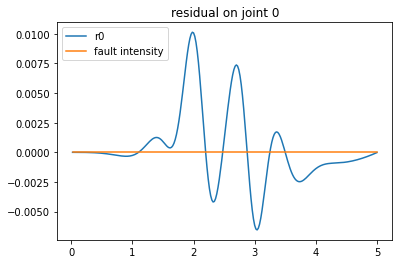

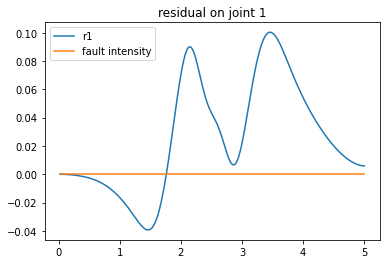

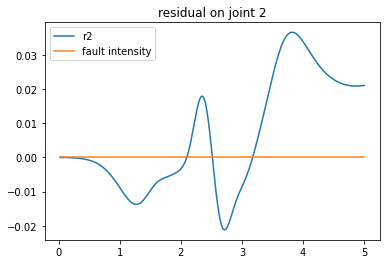

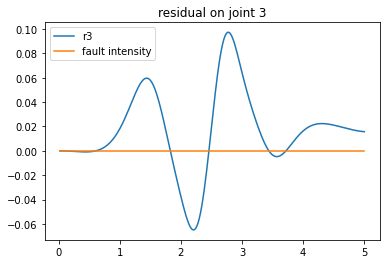

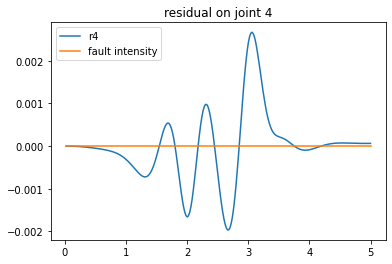

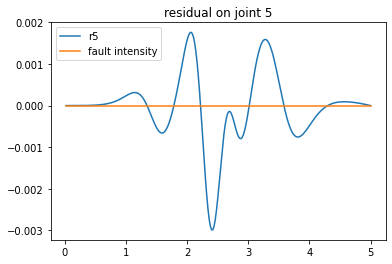

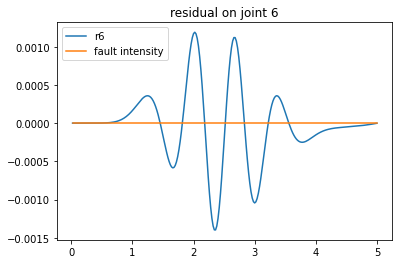

In [19]:
#FDI
for i in range(7):
    fig, ax = plt.subplots()
    ax.set_title("residual on joint "+str(i))
    ax.plot(t, r_residual[:,i], label="r"+str(i))
    ax.plot(t, tau_commanded_history[:,i] - tau_controller_history[:,i], label="fault intensity")
    ax.legend(loc="upper left")

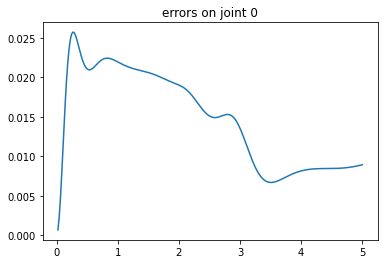

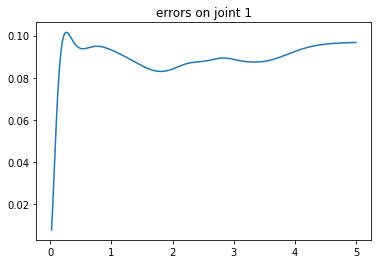

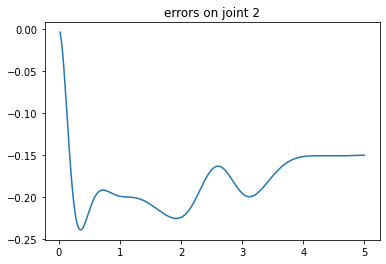

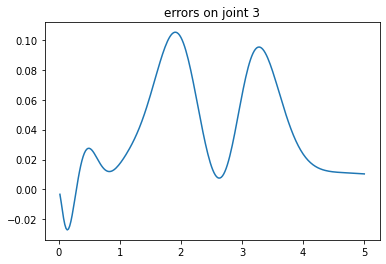

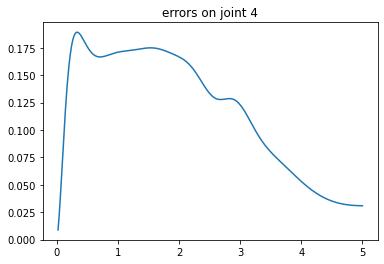

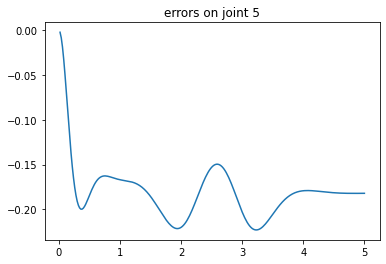

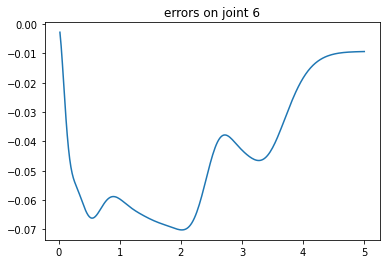

In [178]:
#errors
for i in range(7):
    fig, ax = plt.subplots()
    ax.set_title("errors on joint "+str(i))
    ax.plot(t, qd[1:,i] - q_history[:,i])#e_history[:,i])

In [163]:
#SAFE GRAVITY VECTOR COMPUTATION
geps = 0.00001
v0 = qd[0,:] 
JOINTS_FREEZE = [2]
neutral = False
home = False

for i in range(100000):
    dGnew = []        
    gnew = []
    g = pin.computeGeneralizedGravity(model_reduced, data_reduced, v0)
    dG = pin.computeGeneralizedGravityDerivatives(model_reduced, data_reduced, v0)
    for k in JOINTS_FREEZE:
        dGnew.append(dG[k,:])
        gnew.append(g[k])
    gnew = np.array(gnew)
    dGnew = np.matrix(dGnew)
    
    if np.linalg.norm(gnew) < geps and check_collision_number(v0) and check_constraints_joints(v0): 
        print("FOUND A SAFE POSITION")
        break
    if not check_constraints_joints(v0) or not check_collision_number(v0):
        if not neutral:
            v0 = pin.neutral(model_reduced)
            neutral = True
        elif not home:
            v0 = np.array([0.20, -1.34, -0.20, 1.94, -3.14/2, 1.37, 0.0])
            home = True
        else:
            v0 = pin.randomConfiguration(model_reduced)
    v0 = v0 - np.dot(np.asarray(pinv(dGnew)).reshape(7,len(JOINTS_FREEZE)), gnew)
    
q0[1:8] = v0
viz.display(q0)
pin.computeGeneralizedGravity(model_reduced, data_reduced, v0)

FOUND A SAFE POSITION


array([-6.16736814e-17,  2.15715651e+01, -3.23296945e-13,  5.56599861e+00,
       -5.80323832e-01, -8.06538347e-01,  2.09560637e-02])

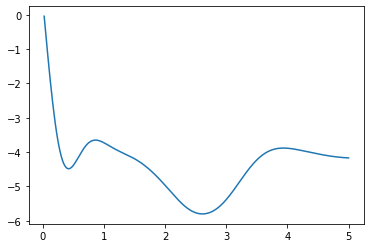

In [191]:
#test on filtering residuals
from scipy import signal
b, a = signal.butter(3, 0.05, btype='lowpass', analog=False)
low_passed = signal.filtfilt(b, a, r_residual[:,3])

fig, ax = plt.subplots()
ax.plot(t, low_passed)

In [21]:
#CHECK IF FORCE ORIGINAL IS OVER THE BOUNDS
tauproblems = False
for i in range(T):
    if (abs(tau_controller_history[i,:]) > model_reduced.effortLimit).any():
        tauproblems = True
print("Has torque limit problems? "+str(tauproblems))

Has torque limit problems? True


# REINFORCEMENT LEARNING START #

In [20]:
#encore, PERTURBED MASSES MODEL
import copy
np.random.seed(42)
model_reduced_perturbed = copy.deepcopy(model_reduced)
#uncomment if willing to test with initial an additional randomizing factor to deturpate the initial model
for i in range(1,8):
    model_reduced_perturbed.inertias[i].mass = model_reduced_perturbed.inertias[i].mass
    
#ALWAYS VARIABLE TEST ENV
np.random.seed(42) #to reproduce results, other used seeds: 0
model_reduced_perturbed_test = copy.deepcopy(model_reduced)
for i in range(1,8):
    model_reduced_perturbed_test.inertias[i].mass = model_reduced_perturbed_test.inertias[i].mass * np.random.uniform(0.75, 0.85)   

In [67]:
import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from cv2 import Rodrigues
from scipy.spatial.transform import Rotation as R

regularization_factor = 5e-5

MAX_INT = 1e6
COLLISION = True

#ADAPTIVE CONTROL + FTC TIAGO
class TiagoEnv(gym.Env):
    """An environment for Tiago-1HAND by PAL Robotics"""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, model_reduced, data_reduced,
                 trajectory_acceleration, trajectory_velocity, trajectory_position,
                 tstep, fault_vector, fault_durations, fixed_trajectory,
                 randomizefaults, internalmodel, rlmodel_adaptive, test, classic_adaptive):
        super(TiagoEnv).__init__()
        
        self.trajectory_acceleration = trajectory_acceleration
        self.trajectory_velocity = trajectory_velocity
        self.trajectory_position = trajectory_position
        self.tstep = tstep
        self.current_step = 0
        self.which_trajectory = 0
        self.episode = 0
        self.realmodel = model_reduced
        self.internalmodel = internalmodel
        self.adaptivemodel = rlmodel_adaptive
        self.cumulated_reward = 0
        self.classic_adaptive = classic_adaptive
        
        self.current_acceleration = self.trajectory_acceleration[0][0,:].copy()
        self.current_velocity = self.trajectory_velocity[0][0,:].copy()
        self.current_position = self.trajectory_position[0][0,:].copy()
        self.current_task = self.dirKin(self.current_position.copy())
                
        self.fault_vector = fault_vector
        self.fault_durations = fault_durations
        
        self.target_acceleration = self.trajectory_acceleration[0][0,:].copy()
        self.target_velocity = self.trajectory_velocity[0][0,:].copy()
        self.target_position = self.trajectory_position[0][0,:].copy()
        self.target_task = self.dirKin(self.target_position.copy())
        self.fixed_trajectory = fixed_trajectory
        
        self.randomizefaults = randomizefaults
        self.chosen_fault = np.argmax(fault_vector)
        self.current_batch = 0
        
        self.actionbase =  None
        
        np.random.seed(0)
        self.global_randomizer_multiplier = np.random.uniform(0.7,1.3,7) #multiplying, on each joint, different
        self.noise_on_masses = np.random.uniform(0.3,1.8,7) #random model noise between +- 50% (on each joint, different)
        self.fault_noise = np.random.uniform(0.8,1.0) #1 #random fault intensity
       
        self.test = test
        if(self.test):
            self.noise_on_masses = np.random.uniform(0.3,0.7,7)
            
        #ada
        for i in range(1,8):
            self.internalmodel.inertias[i].mass = ((self.internalmodel.inertias[i].mass * self.global_randomizer_multiplier[i-1]) * self.noise_on_masses[i-1]) 
        self.classic_adaptive_parameters = np.zeros((70,))
        for y in range(1,8):
            self.classic_adaptive_parameters[(0+10*(y-1)):(10*y)] = self.internalmodel.inertias[y].toDynamicParameters().copy().squeeze()
        for i in range(1,8):
            self.internalmodel.inertias[i].mass = ((self.internalmodel.inertias[i].mass / self.global_randomizer_multiplier[i-1]) / self.noise_on_masses[i-1]) 
        #endada
        
        #residuals
        self.tau_original = [] #torques ideally applied
        self.tau_actual = [] #effective torque applied
        self.r_residual = []
        self.q_history = []
        self.v_history = []
        self.a_history = []
        self.last_action = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        
        # 7 masses multiplier
        self.action_space = spaces.Box(low=np.array([-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7]),
                                       high=np.array([3.0,3.0,3.0,3.0,3.0,3.0,3.0]),                                       
                                       dtype=np.float16)
        if(self.adaptivemodel is not None): #adaptive already trained
            # 7 torques as continuous actions possible
            self.action_space = spaces.Box(low=-model_reduced.effortLimit,
                                           high=model_reduced.effortLimit,
                                           dtype=np.float16)
        # observing: q, q', qd, p, pd
        self.observation_space = spaces.Box(
                                    low=np.concatenate(
                                        (model_reduced.lowerPositionLimit,
                                         -model_reduced.velocityLimit,
                                         model_reduced.lowerPositionLimit
                                         ,-MAX_INT*np.array([1,1,1,1,1,1,1]),
                                         -MAX_INT*np.array([1,1,1,1,1,1,1])
                                        )
                                    ),
                                    high=np.concatenate(
                                        (model_reduced.upperPositionLimit,
                                         model_reduced.velocityLimit,
                                         model_reduced.upperPositionLimit
                                         ,MAX_INT*np.array([1,1,1,1,1,1,1]),
                                         MAX_INT*np.array([1,1,1,1,1,1,1])
                                        )
                                    ),
                                    dtype=np.float16)
        
        #negative reward cost
        self.reward_range = (-MAX_INT, 0)
    
    def _next_observation(self):
        obs = np.concatenate((self.current_position, self.current_velocity,
                              self.target_position
                              ,self.current_task, self.target_task
                             ))
        return obs
    
    def simulateDynamics(self, action):
        #pre-law measurements - based on disturbed model
        q = self.current_position
        v = self.current_velocity
        
        
        
        #MODEL ONTOP
        if (self.adaptivemodel is not None):
            massaction, _states = self.adaptivemodel.predict(self._next_observation(), deterministic=True) 
        else:
            massaction = action
            
        #repeating an already known situation?    
        if self.actionbase is not None:
            massaction += self.actionbase
            massaction = np.clip(massaction, np.array([-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7]),np.array([3.0,3.0,3.0,3.0,3.0,3.0,3.0]))
            
        self.last_action = (self.last_action*self.current_step + massaction.copy())/(self.current_step + 1) #useful for residuals, only masses needed
        
        #change perturbed model masses to attempt to fix them
        for i in range(1,8):
            self.internalmodel.inertias[i].mass = self.internalmodel.inertias[i].mass * self.global_randomizer_multiplier[i-1] * self.noise_on_masses[i-1] * (1.0 + massaction[i-1]) #action[7+i-1]) 
            
        n = pin.rnea(self.internalmodel, data_reduced, q, v, np.zeros((model_reduced.nv))) # C + g
        M = pin.crba(self.internalmodel, data_reduced, q)
        
        #return the perturbed model to the real one
        for i in range(1,8):
            self.internalmodel.inertias[i].mass = (((self.internalmodel.inertias[i].mass / self.global_randomizer_multiplier[i-1]) / self.noise_on_masses[i-1]) / (1.0 + massaction[i-1])) #action[7+i-1]) 
            
        #errors for control
        e = self.trajectory_position[self.which_trajectory][self.current_step,:] - q
        de = self.trajectory_velocity[self.which_trajectory][self.current_step,:] - v
        
    
        
        if not self.classic_adaptive:
            #FBL
            tau_control = np.dot(M, (self.trajectory_acceleration[self.which_trajectory][self.current_step,:] 
                                 + np.dot(Kd, de) +  np.dot(Kp, e)) ) + n
        else:
            #ADAPTIVE
            dqr = self.trajectory_velocity[self.which_trajectory][self.current_step,:] + np.dot(Klambda, e)
            ddqr = self.trajectory_acceleration[self.which_trajectory][self.current_step,:] + np.dot(Klambda, de)
            s = v - dqr
            Ynew = 0.5 * (
                pin.computeJointTorqueRegressor(model_reduced_perturbed, data_reduced, q, v + dqr, ddqr) -
                pin.computeJointTorqueRegressor(model_reduced_perturbed, data_reduced, q, dqr, ddqr) -
                pin.computeJointTorqueRegressor(model_reduced_perturbed, data_reduced, q, v, ddqr) +
                3*pin.computeJointTorqueRegressor(model_reduced_perturbed, data_reduced, q, np.zeros((model_reduced.nv)), ddqr)
            )
            d_parameters = - np.dot(np.dot(Gamma,Ynew.T), s)
            self.classic_adaptive_parameters += d_parameters*self.tstep
            tau_control = np.dot(Ynew, self.classic_adaptive_parameters) - np.dot(Kd, s)
            
        
        if (self.adaptivemodel is not None and self.cumulated_reward < -0.10):
            #emergency stop
            #if self.cumulated_reward < -1.00:
            #    print("emestop")
            #    tau_control = np.dot(M, np.dot(Kd, -v)) + n
            #torque offsets
            tau_control += action
        
        self.tau_original.append(tau_control)
    
        #faults
        tau_control = np.clip(tau_control, -model_reduced.effortLimit, model_reduced.effortLimit) #clipping to possible efforts  
        if self.randomizefaults:
            j = self.chosen_fault
            if self.current_step in self.fault_durations[j]:
                tau_control[j] = (1-self.fault_vector[j]*self.fault_noise)*tau_control[j]     
        else:        
            for j in range(7):
                if self.fault_vector[j] != 0:
                    if self.current_step in self.fault_durations[j]:
                        tau_control[j] = (1-self.fault_vector[j])*tau_control[j]
                        
        self.tau_actual.append(tau_control)

        #print("torque applied")
        #print(tau_control)

        #errors for real model
        for i in range(1,8):
            self.realmodel.inertias[i].mass = self.realmodel.inertias[i].mass * self.global_randomizer_multiplier[i-1] 
 
        #measurements - based on the REAL model, the robot CAN'T see it
        a = pin.aba(self.realmodel, data_reduced, q, v, tau_control) # Forward dynamics
        v += a*self.tstep
        v = np.clip(v, -model_reduced.velocityLimit, model_reduced.velocityLimit)

        q = pin.integrate(self.realmodel, q, v*self.tstep) # Configuration integration
        q = np.clip(q, lowerPositionConstraints, upperPositionConstraints)
        
        self.current_position = q
        self.current_velocity = v
        self.current_acceleration = a   
        
        self.q_history.append(q.copy())
        self.v_history.append(v.copy())
        self.a_history.append(a.copy())
        
        #no more errors for real model
        for i in range(1,8):
            self.realmodel.inertias[i].mass = self.realmodel.inertias[i].mass / self.global_randomizer_multiplier[i-1]
 
        
        #cartesian measurements
        self.current_task = self.dirKin(self.current_position.copy())
        
    def _take_action(self, action):
        self.simulateDynamics(action) # get total torque by controller + action effect
        
        self.target_acceleration = self.trajectory_acceleration[self.which_trajectory][self.current_step,:].copy()
        self.target_velocity = self.trajectory_velocity[self.which_trajectory][self.current_step,:].copy()
        self.target_position = self.trajectory_position[self.which_trajectory][self.current_step,:].copy()
        self.target_task = self.dirKin(self.target_position.copy())
        #print(self.target_task)
        
        return 
    
    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        #jointspace reward OLD
        #reward = -np.power(np.linalg.norm((self.current_position - self.target_position)), 2)
        
        #joint space MSE
        #reward = -np.square(np.subtract(self.current_position, self.target_position)).mean()
        
        #cartesian reward OLD
        reward = -np.power(np.linalg.norm((self.current_task - self.target_task)), 2)
        
        #cartesian space MSE
        #reward = -np.square(np.subtract(self.current_task, self.target_task)).mean()
        
        #mass regularization
        if self.adaptivemodel is None:  
            reward += -regularization_factor*np.power(np.linalg.norm((action)), 2)
        else:          
            #emergency stop!!!
            #if self.cumulated_reward < -1.00: 
            #    reward = -1e-1*np.power(np.linalg.norm((self.current_velocity)), 2)
            pass
            
        self.cumulated_reward += reward
        
        info = {"collision": False, "last_action": self.last_action}
        
        done = False
        # ended trajectory
        if self.current_step == self.trajectory_position[self.which_trajectory].shape[0]: # nsteps x 7 joints
            # done can be changed to true if the condition is met and the acceleration is 0
            done = True
        # collision
        if COLLISION:
            if not check_collision_number(self.current_position): # external
                reward = -MAX_INT
                info["collision"] = True
                done = True

        obs = self._next_observation()
        
        if done:
            self.episode += 1
            '''if self.adaptivemodel is None:
                for i in range(1,8):
                    print("CONVERGED"+str(i))
                    print(self.internalmodel.inertias[i].mass * self.mass_noise * (1+action[i-1]))
                print("----") '''  

        return obs, reward, done, info
    
    def printresidual(self):
        self.tau_original = np.array(self.tau_original)
        self.tau_actual = np.array(self.tau_actual)
        self.r_residual = [0.0*np.array([0,0,0,0,0,0,0])]
        p_hat_residual = 0.0*np.array([0,0,0,0,0,0,0])
        
        #change perturbed model masses to attempt to fix them
        for j in range(1,8):
            self.internalmodel.inertias[j].mass = self.internalmodel.inertias[j].mass * self.global_randomizer_multiplier[j-1] * self.noise_on_masses[j-1]  * (1.0 + self.last_action[j-1])  
        
        for i in range(len(self.q_history)-1):
            g = pin.rnea(self.internalmodel, data_reduced, self.q_history[i], np.zeros((model_reduced.nv)), np.zeros((model_reduced.nv)))
            C = pin.computeCoriolisMatrix(self.internalmodel, data_reduced, self.q_history[i], self.v_history[i])
            M = pin.crba(self.internalmodel, data_reduced, self.q_history[i])
            
            dp_hat_residual = self.tau_original[i] + np.dot(C.T, self.v_history[i]) - g + self.r_residual[i]
            p_hat_residual += dp_hat_residual * self.tstep
            p_residual = np.dot(M, self.v_history[i])
            self.r_residual.append( np.dot(K_residual, ( p_residual - p_hat_residual )) )
    
        #back to correct one
        for j in range(1,8):
            self.internalmodel.inertias[j].mass = (((self.internalmodel.inertias[j].mass / self.global_randomizer_multiplier[j-1]) / self.noise_on_masses[j-1])  / (1.0 + self.last_action[j-1]))
            
        self.r_residual = np.array(self.r_residual)
        
        #FDI
        for i in range(7):
            fig, ax = plt.subplots()
            ax.set_title("residual on joint "+str(i))
            ax.plot(t, self.r_residual[1:,i], label="r"+str(i))
            ax.plot(t, self.tau_actual[1:,i] - self.tau_original[1:,i], label="fault intensity")
            ax.legend(loc="upper left")
    
    def reset(self, start_episode = -1, choose_fault=-1, actionbase=None):
        self.current_step = 0
        self.last_action = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        if actionbase is not None:
            self.actionbase = actionbase
        else:
            self.actionbase = None
        
        if start_episode >= 0:
            self.episode = start_episode
            self.which_trajectory = 0
        else:
            if self.episode < 100:
                self.which_trajectory = 0
            elif self.episode < 200:
                self.which_trajectory = 1
            elif self.episode < 300:
                self.which_trajectory = 2
            else:
                self.which_trajectory = (self.which_trajectory+1)%3
                
        #monotrajectory        
        if(self.fixed_trajectory >= 0):
            self.which_trajectory = self.fixed_trajectory
            
        #faults are randomized
        if(self.randomizefaults):
            if choose_fault >= 0:
                self.current_batch = 0
                self.chosen_fault = choose_fault
            else:    
                self.current_batch += 1
                if self.current_batch == 25 or self.episode > 175: #randomize each episode after 100 times each
                    self.chosen_fault = (self.chosen_fault+1)%7
                    self.current_batch = 0
        
        #fixed fault, if wanted
        #self.chosen_fault = 0
        
        self.adaptive_classic_params = 0
 
        np.random.seed(self.episode)
        self.global_randomizer_multiplier = np.random.uniform(0.7,1.3,7) #multiplying, on each joint, different
        self.noise_on_masses = np.random.uniform(0.3,1.8,7) #random model noise between +- 50% (on each joint, different)
        self.fault_noise = np.random.uniform(0.8,1.0) #1 #random fault intensity
        
        if(self.test):
            self.noise_on_masses = np.random.uniform(0.3,0.7,7)
            
        #ada
        for i in range(1,8):
            self.internalmodel.inertias[i].mass = ((self.internalmodel.inertias[i].mass * self.global_randomizer_multiplier[i-1]) * self.noise_on_masses[i-1]) 
        self.classic_adaptive_parameters = np.zeros((70,))
        for y in range(1,8):
            self.classic_adaptive_parameters[(0+10*(y-1)):(10*y)] = self.internalmodel.inertias[y].toDynamicParameters().copy().squeeze()
        for i in range(1,8):
            self.internalmodel.inertias[i].mass = ((self.internalmodel.inertias[i].mass / self.global_randomizer_multiplier[i-1]) / self.noise_on_masses[i-1]) 
        #endada
            
        self.cumulated_reward = 0
        
        #printing dyn params
        '''for i in range(1,8):
            print("REAL"+str(i))
            print(self.realmodel.inertias[i].mass * self.real_mass_noise)
            print("WRONG"+str(i))
            print(self.internalmodel.inertias[i].mass * self.mass_noise)
        print("----")  '''  
        
        #current values
        self.current_acceleration = self.trajectory_acceleration[self.which_trajectory][0,:].copy()
        self.current_velocity = self.trajectory_velocity[self.which_trajectory][0,:].copy()
        self.current_position = self.trajectory_position[self.which_trajectory][0,:].copy()
        self.current_task = self.dirKin(self.current_position.copy())
        
        #target values
        self.target_acceleration = self.current_acceleration.copy()
        self.target_velocity = self.current_velocity.copy()
        self.target_position = self.current_position.copy()
        self.target_task = self.dirKin(self.target_position.copy())
        
        #currentplot reset
        for i in range(250):
            trajectory_geom_model2.geometryObjects[i].placement = pin.SE3(np.eye(3), np.array([0,0,0]))
        viz3.display(np.zeros(0))
        
        #residuals
        self.tau_original = [] #torques ideally applied
        self.tau_actual = [] #effective torque applied
        self.r_residual = []
        self.q_history = []
        self.v_history = []
        self.a_history = []
        
        return self._next_observation()
    
    def dirKin(self, q):
        q0[1:8] = q
        pin.forwardKinematics(model,data,q0)
        for name, oMi in zip(model.names, data.oMi):
            last_translation = oMi.translation.T.flat
            last_rotation = oMi.rotation.T
            #axis_angle = [last_rotation[2,1] - last_rotation[1,2],
            #              last_rotation[0,2] - last_rotation[2,0],
            #              last_rotation[1,0] - last_rotation[0,1]]
            axis_angle = Rodrigues(last_rotation)[0].squeeze()
            axis_angle = R.from_matrix(last_rotation).as_quat()
            if name == "arm_7_joint":
                break
        return np.concatenate((np.array(last_translation), np.array(axis_angle)))
    
    def render(self, mode='human', close=False):
        #show real
        q0[1:8] = self.current_position
        viz.display(q0)
    
        #plot target
        p = self.dirKin(self.target_position)
        
        trajectory_geom_model.geometryObjects[i].placement = pin.SE3(np.eye(3), p[0:3])
        viz2.display(np.zeros(0))
        
        #plot current
        p = self.dirKin(self.current_position)
        trajectory_geom_model2.geometryObjects[i].placement = pin.SE3(np.eye(3), p[0:3])
        viz3.display(np.zeros(0))
        
        time.sleep(self.tstep)
        
        print(f'Step: {self.current_step}')
        print(f'Error task: {self.current_task - self.target_task}')
        print(f'Error position: {self.current_position - self.target_position}')
        print(f'Error velocity: {self.current_velocity - self.target_velocity}')
        print("---------------------------------")

## ADAPTIVE WITH RL ##

In [68]:
# encore, per comodità
FAULT_VECTOR = [0,0,0,0,0,0,0]
#FAULT_VECTOR = [0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 1]

FAULT_TIME_VECTOR = [range(0,250),
                     range(0,250),
                     range(0,250),
                     range(0,250),
                     range(0,250),
                     range(0,250),
                     range(0,250)] 

#0 CIRCULAR, 1 LINEAR, 2 SINUSOIDAL
fixed_traj = 2

if fixed_traj == 0:
    rladaptive_name = "tmp/FINAL_exp50/best_model-5.zip"
    rlftc_name = "tmp/FINAL_exp54/best_model-3.zip"
elif fixed_traj == 1:
    rladaptive_name = "tmp/FINAL_exp51/best_model-1.zip"
    rlftc_name = "tmp/FINAL_exp55/endtraining.zip"
else:
    rladaptive_name = "tmp/FINAL_exp52/best_model-1.zip"
    rlftc_name = "tmp/FINAL_exp53/best_model-0.zip"

#pretrained weights on other traj [weights trained on 0, used on 1 and 2 never used]
#rladaptive_name = "tmp/FINAL_exp50/best_model-5.zip"
#rlftc_name = "tmp/FINAL_exp54/best_model-3.zip"


randomizefaults = True
adaptivemodel = None
classical_adaptive = False
# The algorithms require a vectorized environment to run
env = TiagoEnv(model_reduced, data_reduced,
                    [circ_ddqd, lin_ddqd, sin_ddqd], 
                    [circ_dqd, lin_dqd, sin_dqd], 
                    [circ_qd, lin_qd, sin_qd],
                    tstep,
                    FAULT_VECTOR, FAULT_TIME_VECTOR, fixed_traj,
                    randomizefaults, model_reduced_perturbed, adaptivemodel, False, classical_adaptive)

eval_env = TiagoEnv(model_reduced, data_reduced,
                    [circ_ddqd, lin_ddqd, sin_ddqd], 
                    [circ_dqd, lin_dqd, sin_dqd], 
                    [circ_qd, lin_qd, sin_qd],
                    tstep,
                    FAULT_VECTOR, FAULT_TIME_VECTOR, fixed_traj,
                    randomizefaults, model_reduced_perturbed_test, adaptivemodel, False, classical_adaptive)

PRODUCTION_env = TiagoEnv(model_reduced, data_reduced,
                    [circ_ddqd, lin_ddqd, sin_ddqd], 
                    [circ_dqd, lin_dqd, sin_dqd], 
                    [circ_qd, lin_qd, sin_qd],
                    tstep,
                    FAULT_VECTOR, FAULT_TIME_VECTOR, fixed_traj,
                    randomizefaults, model_reduced_perturbed, adaptivemodel, True, classical_adaptive)

/home/lollinux/anaconda3/envs/thesis2/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(


In [23]:
# NO TRAINING, TRAIN ENV, test with 0 action so that it executes FBL only - ok for monotraj e randomized faults
START_EPISODE = 300
N_EPISODES = 49

array_reward_ctc = []

obs = env.reset(start_episode=START_EPISODE, choose_fault=0)
total_reward = 0
for j in range(N_EPISODES): # 7 joints
    mean_reward = 0

    for i in range(251):
        action = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        obs, rewards, done, info = env.step(action)
        mean_reward += rewards
        if done:
            break
        #env.render()

    print("FAULTED JOINT "+str(env.chosen_fault)+" reward: " + str(mean_reward))
    if(j==48):
        print()
        #env.printresidual()
    
    obs = env.reset(start_episode=START_EPISODE+1+j, choose_fault=(j+1)%7)
    total_reward += mean_reward
    array_reward_ctc.append(mean_reward)
    #break


print("Total average reward: "+str(total_reward/N_EPISODES))

total_mean_ctc = np.mean(np.array(array_reward_ctc))
total_std_ctc = np.std(np.array(array_reward_ctc))
print(total_mean_ctc)
print(total_std_ctc)

FAULTED JOINT 0 reward: -0.008995571097173496
FAULTED JOINT 1 reward: -22.797563494888312
FAULTED JOINT 2 reward: -0.013050555464527507
FAULTED JOINT 3 reward: -0.08667600205719564
FAULTED JOINT 4 reward: -0.018665185570185202
FAULTED JOINT 5 reward: -0.007170938488987818
FAULTED JOINT 6 reward: -0.015111550148330271
FAULTED JOINT 0 reward: -0.004317604642901216
FAULTED JOINT 1 reward: -0.3143174797946144
FAULTED JOINT 2 reward: -0.010279351039105078
FAULTED JOINT 3 reward: -0.1054964476510927
FAULTED JOINT 4 reward: -0.0067609323849249555
FAULTED JOINT 5 reward: -0.008423910860758829
FAULTED JOINT 6 reward: -0.0033594123217652247
FAULTED JOINT 0 reward: -0.009640800150635887
FAULTED JOINT 1 reward: -0.06395235106723528
FAULTED JOINT 2 reward: -0.05609915228448618
FAULTED JOINT 3 reward: -0.0549468523056065
FAULTED JOINT 4 reward: -0.003970948826122189
FAULTED JOINT 5 reward: -0.021898871119064984
FAULTED JOINT 6 reward: -0.020704588548487106
FAULTED JOINT 0 reward: -0.0330026911430391

In [24]:
# NO TRAINING, TEST ENV, test with 0 action so that it executes FBL only - ok for monotraj e randomized faults
obs = eval_env.reset(start_episode=START_EPISODE, choose_fault=0)
total_reward = 0

array_reward_ctc_test = []

for j in range(N_EPISODES): # 7 joints
    mean_reward = 0

    for i in range(251):
        action = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        obs, rewards, done, info = eval_env.step(action)
        mean_reward += rewards
        if done:
            break
        #eval_env.render()

    print("FAULTED JOINT "+str(eval_env.chosen_fault)+" reward: " + str(mean_reward))
    if(j==48):
        print()
        #eval_env.printresidual()
    
    obs = eval_env.reset(start_episode=START_EPISODE+1+j, choose_fault=(j+1)%7)
    total_reward += mean_reward
    #break
    array_reward_ctc_test.append(mean_reward)
    
print("Total average reward: "+str(total_reward/N_EPISODES))

total_mean_ctc_test = np.mean(np.array(array_reward_ctc_test))
total_std_ctc_test = np.std(np.array(array_reward_ctc_test))
print(total_mean_ctc_test)
print(total_std_ctc_test)

FAULTED JOINT 0 reward: -0.0028224305401679264
FAULTED JOINT 1 reward: -2.458720653672574
FAULTED JOINT 2 reward: -0.04882329248202845
FAULTED JOINT 3 reward: -0.15265500817593602
FAULTED JOINT 4 reward: -0.04891374672200353
FAULTED JOINT 5 reward: -0.004502371819903683
FAULTED JOINT 6 reward: -0.01992831480203011
FAULTED JOINT 0 reward: -0.006832531967131975
FAULTED JOINT 1 reward: -0.33815190905674153
FAULTED JOINT 2 reward: -0.04518544350735274
FAULTED JOINT 3 reward: -0.2094268697704175
FAULTED JOINT 4 reward: -0.041606828535454235
FAULTED JOINT 5 reward: -0.003133319439691924
FAULTED JOINT 6 reward: -0.013178485206611655
FAULTED JOINT 0 reward: -0.03912584346447421
FAULTED JOINT 1 reward: -0.0799343000762997
FAULTED JOINT 2 reward: -0.11103709689886897
FAULTED JOINT 3 reward: -0.05608112788510084
FAULTED JOINT 4 reward: -0.016948276289224355
FAULTED JOINT 5 reward: -0.009600143628325349
FAULTED JOINT 6 reward: -0.03205931923060769
FAULTED JOINT 0 reward: -0.11008497842876673
FAULT

In [25]:
# PRODUCTION ENV
obs = PRODUCTION_env.reset(start_episode=START_EPISODE, choose_fault=0)
total_reward = 0

array_reward_ctc_prod = []

for j in range(N_EPISODES): # 7 joints
    mean_reward = 0

    for i in range(251):
        action = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])  
        obs, rewards, done, info = PRODUCTION_env.step(action)
        mean_reward += rewards
        if done:
            break
        #PRODUCTION_env.render()

    print("FAULTED JOINT "+str(PRODUCTION_env.chosen_fault)+" reward: " + str(mean_reward))
    if(j==48):
        print()
        #PRODUCTION_env.printresidual()
    
    obs = PRODUCTION_env.reset(start_episode=START_EPISODE+1+j, choose_fault=(j+1)%7)
    total_reward += mean_reward
    #break
    array_reward_ctc_prod.append(mean_reward)
    
print("Total average reward: "+str(total_reward/N_EPISODES))

total_mean_ctc_prod = np.mean(np.array(array_reward_ctc_prod))
total_std_ctc_prod = np.std(np.array(array_reward_ctc_prod))
print(total_mean_ctc_prod)
print(total_std_ctc_prod)

FAULTED JOINT 0 reward: -0.21483570227573265
FAULTED JOINT 1 reward: -105.98367751245132
FAULTED JOINT 2 reward: -0.5725579193745837
FAULTED JOINT 3 reward: -0.2916425411818963
FAULTED JOINT 4 reward: -0.10402510781213152
FAULTED JOINT 5 reward: -0.13763650726864343
FAULTED JOINT 6 reward: -0.5733859841846229
FAULTED JOINT 0 reward: -0.07055719038183644
FAULTED JOINT 1 reward: -1.0406461153995197
FAULTED JOINT 2 reward: -0.2069044436810269
FAULTED JOINT 3 reward: -0.3245768584848949
FAULTED JOINT 4 reward: -0.2716308525578746
FAULTED JOINT 5 reward: -0.07853060126682489
FAULTED JOINT 6 reward: -0.15406633840287737
FAULTED JOINT 0 reward: -0.10619047815379598
FAULTED JOINT 1 reward: -0.6259848688602956
FAULTED JOINT 2 reward: -0.5899736069221948
FAULTED JOINT 3 reward: -0.27966990592068713
FAULTED JOINT 4 reward: -0.2306884722670799
FAULTED JOINT 5 reward: -0.35755149366869915
FAULTED JOINT 6 reward: -0.14458504681508458
FAULTED JOINT 0 reward: -0.1976811824934587
FAULTED JOINT 1 reward

In [69]:
# RL TRAINING
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3 import PPO, SAC, DDPG, TD3
import os
import time

#old callback
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.num_saved = 0

    def _on_step(self) -> bool:
        
        if self.n_calls % self.check_freq == 0:
            if self.n_calls <= 187500: #prima della randomizzazione e poco dopo
                print("Can't save weights... too early!")
                return True
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Mean training reward over the last x episodes
                mean_reward = np.mean(y[-7:])
                if self.verbose > 0:
                    print("Num timesteps: {}".format(self.num_timesteps))
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                    self.model.save(self.save_path)
                    self.save_path = os.path.join(log_dir, 'best_model') + str(self.num_saved)
                    self.num_saved += 1

        return True

In [70]:
#rew_callback = SaveOnBestTrainingRewardCallback(check_freq=7000, log_dir="tmp/") # check each completed total batch
eval_env = Monitor(eval_env, "tmp_eval/")
eval_env.reset(start_episode=701, choose_fault=6)

rew_callback = EvalCallback(eval_env, n_eval_episodes=49
                           ,eval_freq=50000, best_model_save_path='./logs/',
                            deterministic=True)
env = Monitor(env, "tmp/")

obs = env.reset(start_episode=0,choose_fault=0)
TRAIN_STEPS = 1750000 #total: 1000 * 250tsteps * 7 joints
LOAD = 'tmp/FINAL_exp52/best_model-5.zip'
LOAD = rladaptive_name

if os.path.exists(LOAD):
    rlmodel = PPO.load(LOAD, verbose=1)
    print("LOADED ADAPTIVE BEST WEIGHTS MODEL")
else:
    rlmodel = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0001)
    rlmodel.learn(total_timesteps=TRAIN_STEPS, callback=[rew_callback])
    rlmodel.save('tmp/endtraining')
    #results_plotter.plot_results(["tmp/"], TRAIN_STEPS, results_plotter.X_TIMESTEPS, "PPO")
    #plt.show()

LOADED ADAPTIVE BEST WEIGHTS MODEL


In [28]:
# NEW - RL EXECUTING on TRAIN ENV
obs = env.reset(start_episode=START_EPISODE, choose_fault=0)
total_reward = 0
for j in range(N_EPISODES): # 7 joints
    mean_reward = 0

    for i in range(251):
        action, _states = rlmodel.predict(obs, deterministic=True) 
        obs, rewards, done, info = env.step(action)
        mean_reward += rewards
        if done:
            break
        #env.render()

    print("FAULTED JOINT "+str(env.chosen_fault)+" reward: " + str(mean_reward))
    if(j==48):
        print()
        #env.printresidual()
    
    obs = env.reset(start_episode=START_EPISODE+1+j, choose_fault=(j+1)%7)
    total_reward += mean_reward
    #break
    
print("Total average reward: "+str(total_reward/N_EPISODES))

FAULTED JOINT 0 reward: -0.02668991176487026
FAULTED JOINT 1 reward: -22.0396691596892
FAULTED JOINT 2 reward: -0.013044826359388684
FAULTED JOINT 3 reward: -0.06895840227908649
FAULTED JOINT 4 reward: -0.03251458878286507
FAULTED JOINT 5 reward: -0.02806638729779445
FAULTED JOINT 6 reward: -0.020262938857726745
FAULTED JOINT 0 reward: -0.018446191076570508
FAULTED JOINT 1 reward: -0.2389073289532162
FAULTED JOINT 2 reward: -0.009849885965337734
FAULTED JOINT 3 reward: -0.053062520425215746
FAULTED JOINT 4 reward: -0.007659738557303132
FAULTED JOINT 5 reward: -0.02721874223715743
FAULTED JOINT 6 reward: -0.014647389302486252
FAULTED JOINT 0 reward: -0.00912562710688164
FAULTED JOINT 1 reward: -0.07291201368451418
FAULTED JOINT 2 reward: -0.02231425334892677
FAULTED JOINT 3 reward: -0.07590267895612797
FAULTED JOINT 4 reward: -0.017586205151402454
FAULTED JOINT 5 reward: -0.04296723952327399
FAULTED JOINT 6 reward: -0.033063349331278996
FAULTED JOINT 0 reward: -0.012467100292789206
FAUL

In [29]:
# NEW - RL EXECUTING on TEST ENV
obs = eval_env.reset(start_episode=START_EPISODE, choose_fault=0)
total_reward = 0
for j in range(N_EPISODES): # 7 joints
    mean_reward = 0

    for i in range(251):
        action, _states = rlmodel.predict(obs, deterministic=True) 
        obs, rewards, done, info = eval_env.step(action)
        mean_reward += rewards
        if done:
            break
        #eval_env.render()

    print("FAULTED JOINT "+str(eval_env.chosen_fault)+" reward: " + str(mean_reward))
    if(j==48):
        print()
        #eval_env.printresidual()
    
    obs = eval_env.reset(start_episode=START_EPISODE+1+j, choose_fault=(j+1)%7)
    total_reward += mean_reward
    #break
    
print("Total average reward: "+str(total_reward/N_EPISODES))

FAULTED JOINT 0 reward: -0.012004002732765483
FAULTED JOINT 1 reward: -21.97163605733637
FAULTED JOINT 2 reward: -0.02063071593062045
FAULTED JOINT 3 reward: -0.0911224183424496
FAULTED JOINT 4 reward: -0.043778187989595194
FAULTED JOINT 5 reward: -0.014875880562012502
FAULTED JOINT 6 reward: -0.00994169458400922
FAULTED JOINT 0 reward: -0.0084577945057727
FAULTED JOINT 1 reward: -0.25656398061277386
FAULTED JOINT 2 reward: -0.017078649057098938
FAULTED JOINT 3 reward: -0.09319290133086616
FAULTED JOINT 4 reward: -0.016624075537045903
FAULTED JOINT 5 reward: -0.013003633851097181
FAULTED JOINT 6 reward: -0.00825838392573954
FAULTED JOINT 0 reward: -0.012236059297344488
FAULTED JOINT 1 reward: -0.07591788109093213
FAULTED JOINT 2 reward: -0.03564133459916004
FAULTED JOINT 3 reward: -0.06796641342018923
FAULTED JOINT 4 reward: -0.015130009690229847
FAULTED JOINT 5 reward: -0.0256015461798154
FAULTED JOINT 6 reward: -0.03180412864523946
FAULTED JOINT 0 reward: -0.04339916075446821
FAULTED

In [30]:
#PROD ENV
obs = PRODUCTION_env.reset(start_episode=START_EPISODE, choose_fault=0)
total_reward = 0
for j in range(N_EPISODES): # 7 joints
    mean_reward = 0

    for i in range(251):
        action, _states = rlmodel.predict(obs, deterministic=True) 
        obs, rewards, done, info = PRODUCTION_env.step(action)
        mean_reward += rewards
        if done:
            break
        #PRODUCTION_env.render()

    print("FAULTED JOINT "+str(PRODUCTION_env.chosen_fault)+" reward: " + str(mean_reward))
    if(j==48):
        print()
        #PRODUCTION_env.printresidual()
    
    obs = PRODUCTION_env.reset(start_episode=START_EPISODE+1+j, choose_fault=(j+1)%7)
    total_reward += mean_reward
    #break
    
print("Total average reward: "+str(total_reward/N_EPISODES))

FAULTED JOINT 0 reward: -0.12014119623433521
FAULTED JOINT 1 reward: -56.08750133202315
FAULTED JOINT 2 reward: -0.25758297471277614
FAULTED JOINT 3 reward: -0.15487545177793102
FAULTED JOINT 4 reward: -0.05469795677940573
FAULTED JOINT 5 reward: -0.07477731133497598
FAULTED JOINT 6 reward: -0.29225423342266355
FAULTED JOINT 0 reward: -0.035242763005773205
FAULTED JOINT 1 reward: -0.6605350897894547
FAULTED JOINT 2 reward: -0.08414154741726838
FAULTED JOINT 3 reward: -0.15455886263448157
FAULTED JOINT 4 reward: -0.147701054190591
FAULTED JOINT 5 reward: -0.04819077309620085
FAULTED JOINT 6 reward: -0.08069998713745465
FAULTED JOINT 0 reward: -0.0514885179272055
FAULTED JOINT 1 reward: -0.4252099339678113
FAULTED JOINT 2 reward: -0.2646967515430603
FAULTED JOINT 3 reward: -0.13835178875210435
FAULTED JOINT 4 reward: -0.11528500628186224
FAULTED JOINT 5 reward: -0.17720013232435344
FAULTED JOINT 6 reward: -0.06843285342335247
FAULTED JOINT 0 reward: -0.09941476147627781
FAULTED JOINT 1 r

## FTC WITH RL ##

In [71]:
# SECONDO encore, per comodità
FAULT_VECTOR_FTC = [0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 1]
FAULT_VECTOR_FTC = [0,0,0,0,0,0,0]
FAULT_VECTOR_FTC = FAULT_VECTOR

FAULT_TIME_VECTOR_FTC = [range(0,250),
                     range(0,250),
                     range(0,250),
                     range(0,250),
                     range(0,250),
                     range(0,250),
                     range(0,250)] 

# The algorithms require a vectorized environment to run
#fixed_traj = 2
randomizefaults = True
adaptivemodel = rlmodel
classical_adaptive = False

env_ftc = TiagoEnv(model_reduced, data_reduced,
                    [circ_ddqd, lin_ddqd, sin_ddqd], 
                    [circ_dqd, lin_dqd, sin_dqd], 
                    [circ_qd, lin_qd, sin_qd],
                    tstep,
                    FAULT_VECTOR_FTC, FAULT_TIME_VECTOR_FTC, fixed_traj,
                    randomizefaults, model_reduced_perturbed, adaptivemodel, False, classical_adaptive)

eval_env_ftc = TiagoEnv(model_reduced, data_reduced,
                    [circ_ddqd, lin_ddqd, sin_ddqd], 
                    [circ_dqd, lin_dqd, sin_dqd], 
                    [circ_qd, lin_qd, sin_qd],
                    tstep,
                    FAULT_VECTOR_FTC, FAULT_TIME_VECTOR_FTC, fixed_traj,
                    randomizefaults, model_reduced_perturbed_test, adaptivemodel, False, classical_adaptive)

PRODUCTION_env_ftc = TiagoEnv(model_reduced, data_reduced,
                    [circ_ddqd, lin_ddqd, sin_ddqd], 
                    [circ_dqd, lin_dqd, sin_dqd], 
                    [circ_qd, lin_qd, sin_qd],
                    tstep,
                    FAULT_VECTOR_FTC, FAULT_TIME_VECTOR_FTC, fixed_traj,
                    randomizefaults, model_reduced_perturbed, adaptivemodel, True, classical_adaptive)

In [32]:
# FTC - NO TRAINING, train env, test with 0 action so that it executes FBL only - ok for monotraj e randomized faults
obs = env_ftc.reset(start_episode=START_EPISODE, choose_fault=0)
total_reward = 0
array_reward_rla = []
for j in range(N_EPISODES): # 7 joints
    mean_reward = 0

    for i in range(251):
        action = np.array([0,0,0,0,0,0,0])
        obs, rewards, done, info = env_ftc.step(action)
        mean_reward += rewards
        if done:
            break
        #env_ftc.render()

    print("FAULTED JOINT "+str(env_ftc.chosen_fault)+" reward: " + str(mean_reward))
    obs = env_ftc.reset(start_episode=START_EPISODE+1+j, choose_fault=(j+1)%7)
    total_reward += mean_reward
    array_reward_rla.append(mean_reward)
    #break
    
print("Total average reward: "+str(total_reward/N_EPISODES))

total_mean_rla = np.mean(np.array(array_reward_rla))
total_std_rla = np.std(np.array(array_reward_rla))
print(total_mean_rla)
print(total_std_rla)

FAULTED JOINT 0 reward: -0.02313202556493661
FAULTED JOINT 1 reward: -22.030415331879517
FAULTED JOINT 2 reward: -0.009071949762375462
FAULTED JOINT 3 reward: -0.06321730560495163
FAULTED JOINT 4 reward: -0.030155109004118587
FAULTED JOINT 5 reward: -0.024913465867659457
FAULTED JOINT 6 reward: -0.015600523638029856
FAULTED JOINT 0 reward: -0.014853028594791496
FAULTED JOINT 1 reward: -0.23673399063285416
FAULTED JOINT 2 reward: -0.005761012447019211
FAULTED JOINT 3 reward: -0.04651361039812713
FAULTED JOINT 4 reward: -0.004002922654622944
FAULTED JOINT 5 reward: -0.023810409982264996
FAULTED JOINT 6 reward: -0.010964308585265594
FAULTED JOINT 0 reward: -0.004763243797465484
FAULTED JOINT 1 reward: -0.07099952563136169
FAULTED JOINT 2 reward: -0.016806918990919822
FAULTED JOINT 3 reward: -0.0724816719824733
FAULTED JOINT 4 reward: -0.014665587606485645
FAULTED JOINT 5 reward: -0.04027717347683881
FAULTED JOINT 6 reward: -0.030858987987349706
FAULTED JOINT 0 reward: -0.00822205383258558

In [33]:
# FTC - NO TRAINING, TEST ENV, test with 0 action so that it executes FBL only - ok for monotraj e randomized faults
obs = eval_env_ftc.reset(start_episode=START_EPISODE, choose_fault=0)
total_reward = 0
array_reward_rla_test = []
for j in range(N_EPISODES): # 7 joints
    mean_reward = 0

    for i in range(251):
        action = np.array([0,0,0,0,0,0,0]) 
        obs, rewards, done, info = eval_env_ftc.step(action)
        mean_reward += rewards
        if done:
            break
        #eval_env_ftc.render()

    print("FAULTED JOINT "+str(eval_env_ftc.chosen_fault)+" reward: " + str(mean_reward))
    obs = eval_env_ftc.reset(start_episode=START_EPISODE+1+j, choose_fault=(j+1)%7)
    total_reward += mean_reward
    #break
    array_reward_rla_test.append(mean_reward)
    
print("Total average reward: "+str(total_reward/N_EPISODES))

total_mean_rla_test = np.mean(np.array(array_reward_rla_test))
total_std_rla_test = np.std(np.array(array_reward_rla_test))
print(total_mean_rla_test)
print(total_std_rla_test)

FAULTED JOINT 0 reward: -0.008397867874490204
FAULTED JOINT 1 reward: -21.961760783896924
FAULTED JOINT 2 reward: -0.016460924998100604
FAULTED JOINT 3 reward: -0.08499086546746418
FAULTED JOINT 4 reward: -0.04133367005480331
FAULTED JOINT 5 reward: -0.01168764006064616
FAULTED JOINT 6 reward: -0.005155922753539607
FAULTED JOINT 0 reward: -0.004845592507638581
FAULTED JOINT 1 reward: -0.2542759288583809
FAULTED JOINT 2 reward: -0.012798500225767945
FAULTED JOINT 3 reward: -0.08627280142648296
FAULTED JOINT 4 reward: -0.01285186132978298
FAULTED JOINT 5 reward: -0.009589109868968637
FAULTED JOINT 6 reward: -0.004515194040597436
FAULTED JOINT 0 reward: -0.007677889152901562
FAULTED JOINT 1 reward: -0.07394686914688071
FAULTED JOINT 2 reward: -0.02987848902125712
FAULTED JOINT 3 reward: -0.06440899404776107
FAULTED JOINT 4 reward: -0.012160558294649498
FAULTED JOINT 5 reward: -0.022963885673032015
FAULTED JOINT 6 reward: -0.029548583500508607
FAULTED JOINT 0 reward: -0.03892787466207389
F

In [34]:
# PROD FTC
obs = PRODUCTION_env_ftc.reset(start_episode=START_EPISODE, choose_fault=0)
total_reward = 0
array_reward_rla_prod=[]
for j in range(N_EPISODES): # 7 joints
    mean_reward = 0

    for i in range(251):
        action = np.array([0,0,0,0,0,0,0]) 
        obs, rewards, done, info = PRODUCTION_env_ftc.step(action)
        mean_reward += rewards
        if done:
            break
        #PRODUCTION_env_ftc.render()

    print("FAULTED JOINT "+str(PRODUCTION_env_ftc.chosen_fault)+" reward: " + str(mean_reward))
    obs = PRODUCTION_env_ftc.reset(start_episode=START_EPISODE+1+j, choose_fault=(j+1)%7)
    total_reward += mean_reward
    #break
    array_reward_rla_prod.append(mean_reward)
    
print("Total average reward: "+str(total_reward/N_EPISODES))

total_mean_rla_prod = np.mean(np.array(array_reward_rla_prod))
total_std_rla_prod = np.std(np.array(array_reward_rla_prod))
print(total_mean_rla_prod)
print(total_std_rla_prod)

FAULTED JOINT 0 reward: -0.11698171487623944
FAULTED JOINT 1 reward: -56.07489323508406
FAULTED JOINT 2 reward: -0.251617855133025
FAULTED JOINT 3 reward: -0.14984185014325788
FAULTED JOINT 4 reward: -0.05136939939097629
FAULTED JOINT 5 reward: -0.07158273843882416
FAULTED JOINT 6 reward: -0.28802075460892373
FAULTED JOINT 0 reward: -0.031925981772040424
FAULTED JOINT 1 reward: -0.6572571606084968
FAULTED JOINT 2 reward: -0.07883336800432739
FAULTED JOINT 3 reward: -0.14911976952953465
FAULTED JOINT 4 reward: -0.1441283237512469
FAULTED JOINT 5 reward: -0.04548891692163448
FAULTED JOINT 6 reward: -0.07746338176930104
FAULTED JOINT 0 reward: -0.047982324817598766
FAULTED JOINT 1 reward: -0.42241232435379567
FAULTED JOINT 2 reward: -0.2580105956705704
FAULTED JOINT 3 reward: -0.13292790852407
FAULTED JOINT 4 reward: -0.11115556936142211
FAULTED JOINT 5 reward: -0.1727552320160533
FAULTED JOINT 6 reward: -0.06443246300151756
FAULTED JOINT 0 reward: -0.09577477461785157
FAULTED JOINT 1 rew

In [72]:
eval_env_ftc = Monitor(eval_env_ftc, "tmp_eval/")
eval_env_ftc.reset(start_episode=701, choose_fault=6)

rew_callback_ftc = EvalCallback(eval_env_ftc, n_eval_episodes=5*49, eval_freq=50000,
                                best_model_save_path='./logs/', deterministic=True)
env_ftc = Monitor(env_ftc, "tmp/")

obs = env_ftc.reset(start_episode=0, choose_fault=0)
TRAIN_STEPS = 1750000 #normally total: 1000 * 250tsteps * 7 joints
LOAD = 'tmp/FINAL_exp53/best_model-0.zip'
LOAD = rlftc_name

if os.path.exists(LOAD):
    rlmodel_ftc = PPO.load(LOAD, verbose=1)
    print("Loaded best FTC Model")
else:
    rlmodel_ftc = PPO("MlpPolicy", env_ftc, verbose=1, learning_rate=0.0001)
    rlmodel_ftc.learn(total_timesteps=TRAIN_STEPS, callback=[rew_callback_ftc])
    rlmodel_ftc.save('tmp/endtraining')

Loaded best FTC Model


In [36]:
# NEW - RL FTC EXECUTING on TRAIN ENV
obs = env_ftc.reset(start_episode=START_EPISODE, choose_fault=0)
total_reward = 0
array_reward_rlftc = []
for j in range(N_EPISODES): # 7 joints
    mean_reward = 0

    for i in range(251):
        action, _states = rlmodel_ftc.predict(obs, deterministic=True) 
        obs, rewards, done, info = env_ftc.step(action)
        mean_reward += rewards
        if done:
            break
        #env_ftc.render()

    print("FAULTED JOINT "+str(env_ftc.chosen_fault)+" reward: " + str(mean_reward))
    obs = env_ftc.reset(start_episode=START_EPISODE+1+j, choose_fault=(j+1)%7)
    total_reward += mean_reward
    #break
    array_reward_rlftc.append(mean_reward)
    
print("Total average reward: "+str(total_reward/N_EPISODES))

total_mean_rlftc = np.mean(np.array(array_reward_rlftc))
total_std_rlftc = np.std(np.array(array_reward_rlftc))
print(total_mean_rlftc)
print(total_std_rlftc)

FAULTED JOINT 0 reward: -0.023132025564936903
FAULTED JOINT 1 reward: -19.899177464072565
FAULTED JOINT 2 reward: -0.00907194976237554
FAULTED JOINT 3 reward: -0.06321730560495169
FAULTED JOINT 4 reward: -0.030155109004119503
FAULTED JOINT 5 reward: -0.024913465867659787
FAULTED JOINT 6 reward: -0.015600523638029684
FAULTED JOINT 0 reward: -0.014853028594791666
FAULTED JOINT 1 reward: -0.48025401278020097
FAULTED JOINT 2 reward: -0.005761012447019254
FAULTED JOINT 3 reward: -0.04651361039812664
FAULTED JOINT 4 reward: -0.004002922654622999
FAULTED JOINT 5 reward: -0.023810409982265295
FAULTED JOINT 6 reward: -0.010964308585265722
FAULTED JOINT 0 reward: -0.0047632437974654525
FAULTED JOINT 1 reward: -0.07099952563136382
FAULTED JOINT 2 reward: -0.0168069189909196
FAULTED JOINT 3 reward: -0.07248167198247395
FAULTED JOINT 4 reward: -0.014665587606486034
FAULTED JOINT 5 reward: -0.0402771734768394
FAULTED JOINT 6 reward: -0.030858987987350102
FAULTED JOINT 0 reward: -0.008222053832585627

In [37]:
# NEW - RL FTC EXECUTING on TEST ENV
obs = eval_env_ftc.reset(start_episode=START_EPISODE, choose_fault=0)
total_reward = 0
array_reward_rlftc_test = []
for j in range(N_EPISODES): # 7 joints
    mean_reward = 0

    for i in range(251):
        action, _states = rlmodel_ftc.predict(obs, deterministic=True) 
        obs, rewards, done, info = eval_env_ftc.step(action)
        mean_reward += rewards
        if done:
            break
        #eval_env_ftc.render()

    print("FAULTED JOINT "+str(eval_env_ftc.chosen_fault)+" reward: " + str(mean_reward))
    obs = eval_env_ftc.reset(start_episode=START_EPISODE+1+j, choose_fault=(j+1)%7)
    total_reward += mean_reward
    #break #to test only 1
    array_reward_rlftc_test.append(mean_reward)
    
print("Total average reward: "+str(total_reward/N_EPISODES))

total_mean_rlftc_test = np.mean(np.array(array_reward_rlftc_test))
total_std_rlftc_test = np.std(np.array(array_reward_rlftc_test))
print(total_mean_rlftc_test)
print(total_std_rlftc_test)

FAULTED JOINT 0 reward: -0.008397867874490159
FAULTED JOINT 1 reward: -3.924174712640742
FAULTED JOINT 2 reward: -0.016460924998100594
FAULTED JOINT 3 reward: -0.08499086546746418
FAULTED JOINT 4 reward: -0.04133367005480331
FAULTED JOINT 5 reward: -0.01168764006064616
FAULTED JOINT 6 reward: -0.005155922753539607
FAULTED JOINT 0 reward: -0.004845592507638581
FAULTED JOINT 1 reward: -0.535883464050455
FAULTED JOINT 2 reward: -0.012798500225768096
FAULTED JOINT 3 reward: -0.08627280142648304
FAULTED JOINT 4 reward: -0.012851861329782976
FAULTED JOINT 5 reward: -0.009589109868968597
FAULTED JOINT 6 reward: -0.004515194040597436
FAULTED JOINT 0 reward: -0.007677889152901562
FAULTED JOINT 1 reward: -0.07394686914688071
FAULTED JOINT 2 reward: -0.02987848902125712
FAULTED JOINT 3 reward: -0.06440899404776107
FAULTED JOINT 4 reward: -0.012160558294649498
FAULTED JOINT 5 reward: -0.022963885673032015
FAULTED JOINT 6 reward: -0.029548583500508607
FAULTED JOINT 0 reward: -0.03892787466207389
FA

In [38]:
# final - PROD FTC
obs = PRODUCTION_env_ftc.reset(start_episode=START_EPISODE, choose_fault=0)
total_reward = 0
array_reward_rlftc_prod = []
for j in range(N_EPISODES): # 7 joints
    mean_reward = 0

    for i in range(251):
        action, _states = rlmodel_ftc.predict(obs, deterministic=True) 
        obs, rewards, done, info = PRODUCTION_env_ftc.step(action)
        mean_reward += rewards
        if done:
            break
        #PRODUCTION_env_ftc.render()

    print("FAULTED JOINT "+str(PRODUCTION_env_ftc.chosen_fault)+" reward: " + str(mean_reward))
    obs = PRODUCTION_env_ftc.reset(start_episode=START_EPISODE+1+j, choose_fault=(j+1)%7)
    total_reward += mean_reward
    #break #to test only 1
    array_reward_rlftc_prod.append(mean_reward)
    
print("Total average reward: "+str(total_reward/N_EPISODES))

total_mean_rlftc_prod = np.mean(np.array(array_reward_rlftc_prod))
total_std_rlftc_prod = np.std(np.array(array_reward_rlftc_prod))
print(total_mean_rlftc_prod)
print(total_std_rlftc_prod)

FAULTED JOINT 0 reward: -0.17424682954844015
FAULTED JOINT 1 reward: -41.63813461401184
FAULTED JOINT 2 reward: -0.6281151644601574
FAULTED JOINT 3 reward: -0.19026551060751332
FAULTED JOINT 4 reward: -0.05136939939097579
FAULTED JOINT 5 reward: -0.07158273843882312
FAULTED JOINT 6 reward: -0.7160128321263103
FAULTED JOINT 0 reward: -0.0319259817720396
FAULTED JOINT 1 reward: -1.2527579507981284
FAULTED JOINT 2 reward: -0.07883336800432575
FAULTED JOINT 3 reward: -0.23045883119914898
FAULTED JOINT 4 reward: -0.3766101993954096
FAULTED JOINT 5 reward: -0.04548891692163375
FAULTED JOINT 6 reward: -0.07746338176929941
FAULTED JOINT 0 reward: -0.04798232481759747
FAULTED JOINT 1 reward: -0.8162072041379961
FAULTED JOINT 2 reward: -0.6576195819076006
FAULTED JOINT 3 reward: -0.16680366645073366
FAULTED JOINT 4 reward: -0.1548237228833278
FAULTED JOINT 5 reward: -0.4295380152521848
FAULTED JOINT 6 reward: -0.06443246300151675
FAULTED JOINT 0 reward: -0.09577477461785053
FAULTED JOINT 1 rewar

# RESIDUALS

[0. 0. 0. 0. 0. 0. 0.]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[0. 0. 0. 0. 0. 0. 0.]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[0. 0. 0. 0. 0. 0. 0.]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[0. 0. 0. 0. 0. 0. 0.]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[0. 0. 0. 0. 0. 0. 0.]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[0. 0. 0. 0. 0. 0. 0.]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[0. 0. 0. 0. 0. 0. 0.]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[0. 0. 0. 0. 0. 0. 0.]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[0. 0. 0. 0. 0. 0. 0.]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[0. 0. 0. 0. 0. 0. 0.]
[0.3873733  0.61452969 0.30001911 0.60955757 0.687

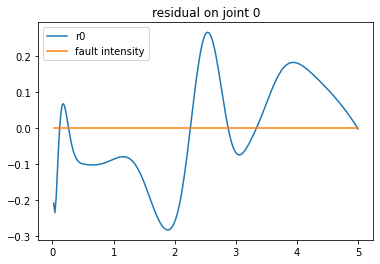

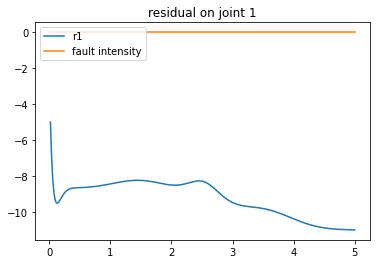

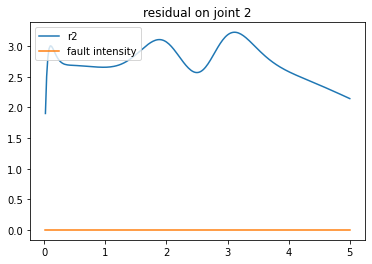

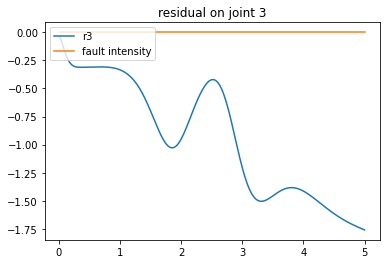

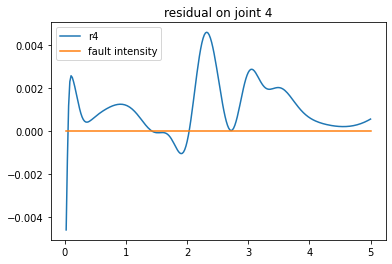

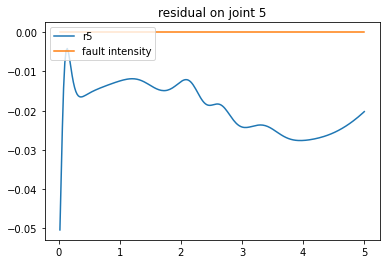

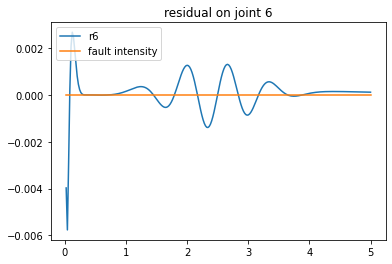

In [79]:
# PRODUCTION ENV - ctc

totrew0 = 0

for j in range(1, N_EPISODES):
    obs = PRODUCTION_env.reset(start_episode=START_EPISODE+j, choose_fault=j%7)
    for k in range(1):
        mean_reward = 0

        for i in range(251):
            action = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])  
            obs, rewards, done, info = PRODUCTION_env.step(action)
            mean_reward += rewards
            if done:
                break
            #PRODUCTION_env.render()
        
        totrew0 += mean_reward
        

        print("FAULTED JOINT "+str(PRODUCTION_env.chosen_fault)+" reward: " + str(mean_reward))
        if k == 0 and j == 1:
            PRODUCTION_env.printresidual()
        print("---------")

        obs = PRODUCTION_env.reset(start_episode=START_EPISODE+j, choose_fault=j%7)
    print("%%%%%%%%%")
    if j == 1:
        break
    
print("totrew0: "+str(totrew0/N_EPISODES))


FAULTED JOINT 0 reward: -0.17867507894730872
---------
FAULTED JOINT 0 reward: -0.135769345438864
---------
FAULTED JOINT 0 reward: -0.09883655859679902
---------
FAULTED JOINT 0 reward: -0.06963524258712193
---------
FAULTED JOINT 0 reward: -0.04765727660939409
---------
FAULTED JOINT 0 reward: -0.031632194997519486
---------
FAULTED JOINT 0 reward: -0.020288204819000594
---------
FAULTED JOINT 0 reward: -0.01252292874891569
---------
FAULTED JOINT 0 reward: -0.0074741681088508725
---------
FAULTED JOINT 0 reward: -0.004490459010488843
---------
%%%%%%%%%
FAULTED JOINT 1 reward: -0.040638830437220844
---------
FAULTED JOINT 1 reward: -0.025747213717205033
---------
FAULTED JOINT 1 reward: -0.014825314285595569
---------
FAULTED JOINT 1 reward: -0.007892023191361109
---------
FAULTED JOINT 1 reward: -0.004332698688163275
---------
FAULTED JOINT 1 reward: -0.003375011276302971
---------
FAULTED JOINT 1 reward: -0.004324622515821613
---------
FAULTED JOINT 1 reward: -0.003375011276302976

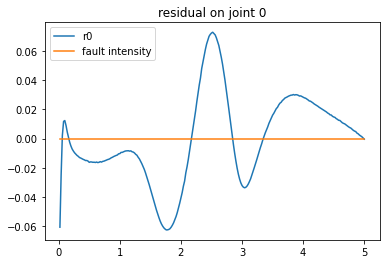

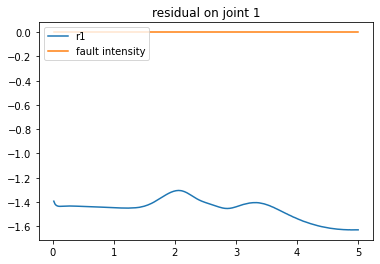

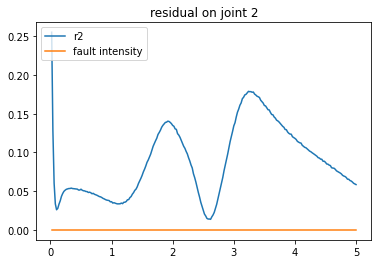

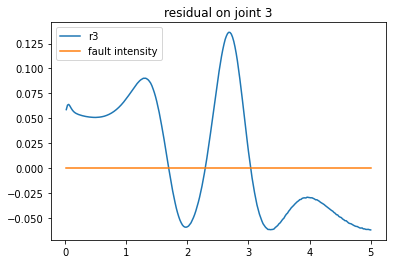

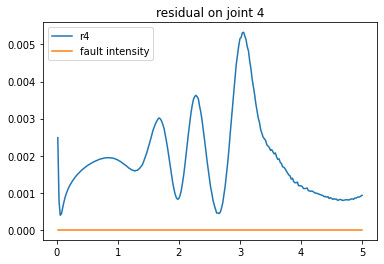

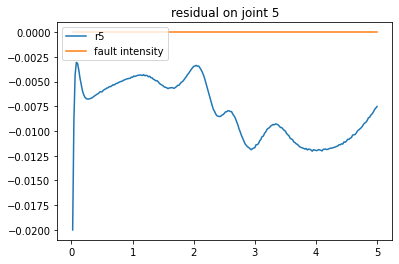

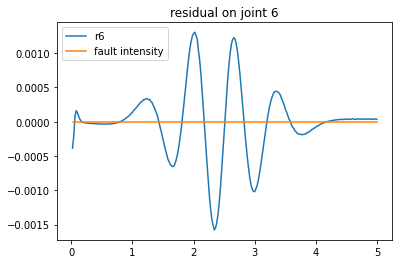

In [75]:
# PRODUCTION ENV - rla
totrew = [0,0,0,0,0,0,0,0,0,0]
for j in range(N_EPISODES):
    best_weights = None
    best_reward = -999
    flag = False
    obs = PRODUCTION_env_ftc.reset(start_episode=START_EPISODE+j, choose_fault=j%7)
    for k in range(10):
        mean_reward = 0

        for i in range(251):
            action = np.array([0,0,0,0,0,0,0])
            obs, rewards, done, info = PRODUCTION_env_ftc.step(action)
            mean_reward += rewards
            if done:
                break
            #PRODUCTION_env_ftc.render()
            
        totrew[k] += mean_reward
        if mean_reward > best_reward:
            best_reward = mean_reward
            if best_weights is not None:
                old_best_weights = best_weights.copy()
            else:
                old_best_weights = None
            
            if not flag:
                best_weights = info['last_action']
            
        if mean_reward < best_reward:
            best_weights = old_best_weights
            flag = True
            
        print("FAULTED JOINT "+str(PRODUCTION_env_ftc.chosen_fault)+" reward: " + str(mean_reward))
        if k == 9 and j == 1:
            PRODUCTION_env_ftc.printresidual()
        print("---------")

        obs = PRODUCTION_env_ftc.reset(start_episode=START_EPISODE+j, choose_fault=j%7, actionbase=best_weights)
    print("%%%%%%%%%")
    if j== 1:
        break

for i in range(10):
    print("totrew"+str(i)+": "+str(totrew[i]/N_EPISODES))

[-0.1370386  -0.59117115 -0.06250538  0.37067521  0.20532535 -0.05523065
  0.15171112]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.11767419 -0.54830444 -0.02372332  0.3429611   0.24361304 -0.05066112
  0.16898974]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.10467192 -0.51339434  0.0165581   0.32444997  0.26134625 -0.05251027
  0.16808579]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.09693647 -0.49023838  0.05258018  0.31515182  0.26697912 -0.05735935
  0.15833538]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.09302678 -0.47724354  0.08271957  0.31290823  0.26553365 -0.06329993
  0.14497951]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.09165399 -0.47133742  0.10751809  0.31524869  0.25990138 -0.06950107
  0.13038836]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662

[-1.64710337e-01 -4.08139817e-01  2.11321805e-01  3.79517939e-01
 -2.75810747e-04 -5.04604210e-02  1.38567812e-02]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.16488358 -0.40697945  0.21163407  0.37860883 -0.00044767 -0.05091018
  0.01298239]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.16505317 -0.4058436   0.21188981  0.3776765  -0.00057689 -0.05136087
  0.01211692]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.16521785 -0.4047294   0.21209629  0.37672249 -0.00066449 -0.0518118
  0.01126061]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.16537776 -0.40363841  0.21225619  0.37574629 -0.00071016 -0.05226359
  0.01040931]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.16553351 -0.40257342  0.21237136  0.37475142 -0.00071296 -0.05271504
  0.00956468]
[0.3873733  0.61452969 0.30001911 0.60955757 0.6879

[-0.32266052 -0.69287792  0.41013358  0.71582376  0.06381399 -0.13050687
  0.00446929]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.32330821 -0.69218877  0.41097091  0.71552287  0.06106053 -0.13052773
  0.00328444]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.32394506 -0.69150996  0.41160416  0.71512672  0.05837636 -0.1305447
  0.00214526]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.3245694  -0.69085628  0.41202225  0.71464273  0.0557775  -0.13055137
  0.0010657 ]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-3.25179343e-01 -6.90234349e-01  4.12231723e-01  7.14074774e-01
  5.32709351e-02 -1.30547504e-01  4.43095216e-05]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.32577429 -0.6896561   0.41223062  0.71343179  0.0508696  -0.13053045
 -0.00091096]
[0.3873733  0.61452969 0.30001911 0.60955757 0.6879

[-0.48194353 -0.7         0.39278451  0.9559358   0.24588994 -0.21281319
  0.0512467 ]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.4823445  -0.7         0.39270124  0.95635941  0.24439633 -0.21255051
  0.0508658 ]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.48273531 -0.7         0.39255265  0.95675461  0.24293754 -0.21224578
  0.05056088]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.48312099 -0.7         0.39233858  0.95712508  0.24151083 -0.2118964
  0.05033303]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.48349317 -0.7         0.39214943  0.95747848  0.24008809 -0.21153007
  0.05012232]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.48386199 -0.7         0.39185258  0.95781874  0.23870672 -0.211108
  0.05001635]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[

[-0.53304871 -0.7         0.37647096  0.90853439  0.11558546 -0.1641041
  0.03073446]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.53319195 -0.7         0.37584548  0.90734562  0.11617888 -0.16432112
  0.03027554]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.53333577 -0.7         0.3752259   0.90615922  0.11676449 -0.16453432
  0.02982131]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.5334787  -0.7         0.37462736  0.90497373  0.11733879 -0.16474774
  0.02936105]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.53362208 -0.7         0.37403925  0.90379166  0.11790492 -0.16495884
  0.02890338]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.53376418 -0.7         0.37347349  0.90261147  0.11845942 -0.16517122
  0.02843891]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]

[-0.6888715  -0.7         0.41220024  1.24116204  0.16788112 -0.18939969
  0.11150885]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.68895156 -0.7         0.41037191  1.24063117  0.16868977 -0.18858627
  0.1128372 ]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.68903048 -0.7         0.40873177  1.24014317  0.16944156 -0.18781899
  0.11407061]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.68910827 -0.7         0.40726356  1.23969657  0.17013484 -0.18709579
  0.11521411]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.68918498 -0.7         0.40596977  1.23928832  0.1707659  -0.18642056
  0.11625973]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.68926061 -0.7         0.40486824  1.23891783  0.17132453 -0.18579998
  0.11719121]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662

[-0.7        -0.7         0.40989442  1.51970727  0.33774124 -0.2581916
  0.17767613]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.41074861  1.52031321  0.33647112 -0.25729723
  0.17818929]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.4117175   1.52095278  0.33518028 -0.25640975
  0.17867812]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.41281113  1.52162629  0.33386435 -0.2555345
  0.17913209]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.4140206   1.52233787  0.33252727 -0.25467081
  0.17955842]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.41537797  1.52308449  0.3311506  -0.25382843
  0.17992593]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]


[-0.7        -0.7         0.38379109  1.44046423  0.26195578 -0.23278564
  0.14636023]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38347476  1.43932815  0.26238038 -0.23301341
  0.14583938]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38319138  1.43819761  0.26279055 -0.23324631
  0.14530558]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38293939  1.43707274  0.26318772 -0.23348492
  0.14475867]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38271853  1.43595434  0.26357058 -0.23372846
  0.14419958]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38252528  1.43484191  0.26394207 -0.23397654
  0.14363016]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662

[-0.7        -0.7         0.37571619  1.78243462  0.3180475  -0.24130405
  0.26101416]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.37524774  1.78215674  0.31831705 -0.24088611
  0.26153241]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.37494302  1.78189626  0.31850686 -0.24052688
  0.26193081]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.37478906  1.78164787  0.3186206  -0.2402259
  0.262213  ]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.37476543  1.78140575  0.31866118 -0.23997914
  0.26238818]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.37488761  1.78116416  0.31862659 -0.2397934
  0.26244268]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]


[-0.7        -0.7         0.35325271  2.06033483  0.48552255 -0.30782957
  0.33280213]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.3543712   2.06098764  0.48422521 -0.30694695
  0.33326895]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.35560198  2.06167309  0.48290523 -0.30607639
  0.33370498]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.35695241  2.06239386  0.48155736 -0.3052195
  0.33410527]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.35845242  2.06315482  0.48017017 -0.30438487
  0.33445001]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.36008717  2.06394842  0.47874397 -0.30357446
  0.33473463]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]

[-0.7        -0.7         0.32272442  1.96095036  0.4204479  -0.28804347
  0.29197314]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.3229632   1.95992694  0.42065913 -0.28837202
  0.2912163 ]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.32323612  1.95891143  0.42085818 -0.2887074
  0.29044314]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.32354447  1.95790439  0.42104578 -0.28905066
  0.28965207]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.32388873  1.95690612  0.42122025 -0.28940131
  0.28884328]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.32426168  1.9559167   0.42138517 -0.2897579
  0.28802112]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]


[-0.7        -0.7         0.37998473  1.77768374  0.3156839  -0.24050869
  0.25853017]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38061887  1.77715188  0.31527643 -0.24078094
  0.25784016]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38124235  1.77658005  0.31487443 -0.24108062
  0.25711753]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38184374  1.77596912  0.31448395 -0.24140288
  0.2563701 ]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38242144  1.77531938  0.31411015 -0.2417464
  0.25559947]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38295897  1.77463247  0.31375944 -0.24210524
  0.25481893]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]

[-0.7        -0.7         0.43722639  1.81153532  0.37189767 -0.27046284
  0.24959122]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.44045347  1.81253207  0.36938723 -0.27026548
  0.2485115 ]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.44366201  1.81349123  0.36680741 -0.27010201
  0.24736437]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.44685132  1.81440586  0.36415359 -0.26997512
  0.24614466]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.45000453  1.81526769  0.36143155 -0.26988444
  0.24485673]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.4531073   1.81607103  0.35864141 -0.26982959
  0.24350332]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662

[-0.7        -0.7         0.32398647  1.78293407  0.47431469 -0.29625601
  0.27917472]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.3342685   1.77247757  0.48233797 -0.29765373
  0.28104348]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.34537226  1.76741672  0.48476542 -0.30012048
  0.27776144]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.35461631  1.7656419   0.4844026  -0.30241426
  0.2732793 ]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.36230003  1.76571662  0.48254853 -0.304424
  0.26854667]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.36851846  1.76670567  0.48004523 -0.30608956
  0.26412186]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]


[-0.7        -0.7         0.3856179   1.76892637  0.31219904 -0.24495906
  0.24912866]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38580047  1.76800508  0.312139   -0.24538917
  0.24832386]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38594032  1.7670633   0.31211974 -0.2458228
  0.24751984]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38601797  1.76610129  0.31214723 -0.2462531
  0.24673025]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38604507  1.76512112  0.3122207  -0.2466828
  0.24594981]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[-0.7        -0.7         0.38602315  1.76412362  0.31233816 -0.24711075
  0.24517785]
[0.3873733  0.61452969 0.30001911 0.60955757 0.68799898 0.66234617
 0.69800662]
[

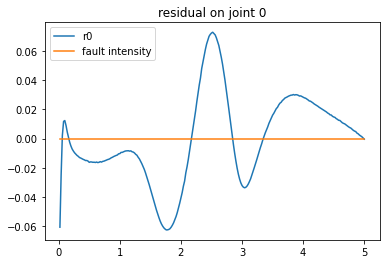

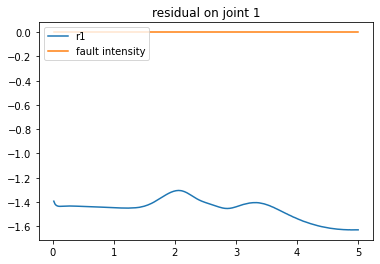

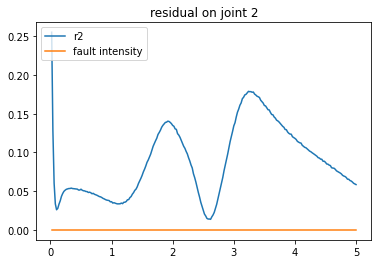

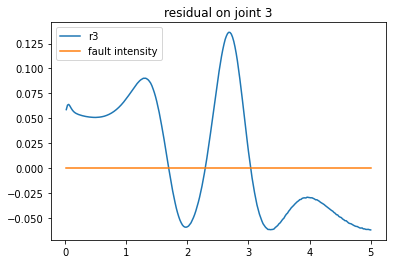

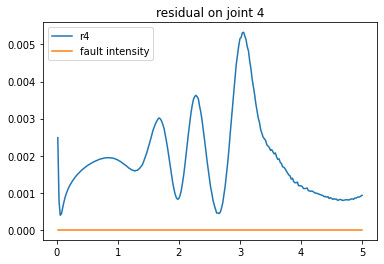

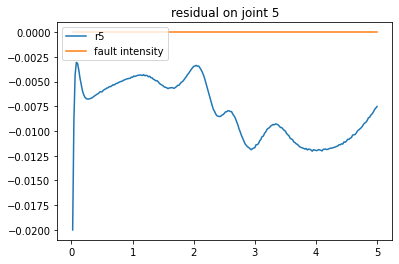

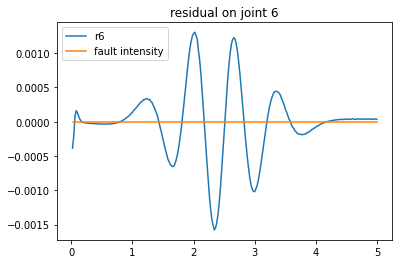

In [82]:
# PRODUCTION ENV - rlftc
totrew = [0,0,0,0,0,0,0,0,0,0]

ftc_masses = []

for j in range(1, N_EPISODES):
    best_weights = None
    best_reward = -999
    old_best_weights = None
    flag = False
    obs = PRODUCTION_env_ftc.reset(start_episode=START_EPISODE+j, choose_fault=j%7)
    for k in range(10):
        mean_reward = 0
        

        for i in range(251):
            action, _states = rlmodel_ftc.predict(obs, deterministic=True) 
            obs, rewards, done, info = PRODUCTION_env_ftc.step(action)
            mean_reward += rewards
            if done:
                break
            #PRODUCTION_env_ftc.render()
            print(PRODUCTION_env_ftc.last_action)
            print(PRODUCTION_env_ftc.noise_on_masses)
            ftc_masses.append(PRODUCTION_env_ftc.last_action)
            
        totrew[k] += mean_reward
        if mean_reward > best_reward:
            best_reward = mean_reward
            if best_weights is not None:
                old_best_weights = best_weights.copy()
            else:
                old_best_weights = None
        
            if not flag:
                best_weights = info['last_action']
            
        if mean_reward < best_reward:
            best_weights = old_best_weights
            flag = True
            
        print("FAULTED JOINT "+str(PRODUCTION_env_ftc.chosen_fault)+" reward: " + str(mean_reward))
        if k == 9 and j == 1:
            PRODUCTION_env_ftc.printresidual()
        print("---------")

        obs = PRODUCTION_env_ftc.reset(start_episode=START_EPISODE+j, choose_fault=j%7, actionbase=best_weights)
    print("%%%%%%%%%")
    if j==1:
        break
    
for i in range(10):
    print("totrew"+str(i)+": "+str(totrew[i]/N_EPISODES))

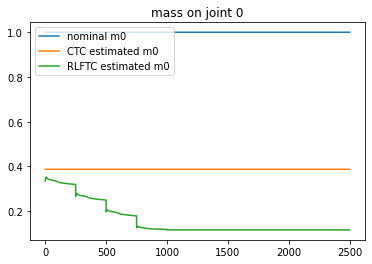

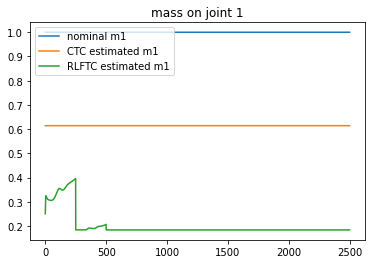

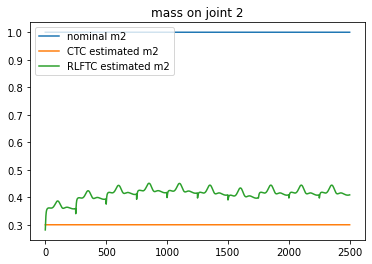

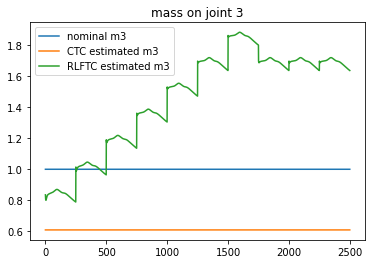

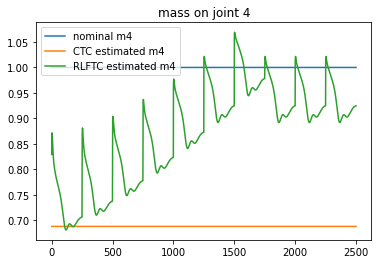

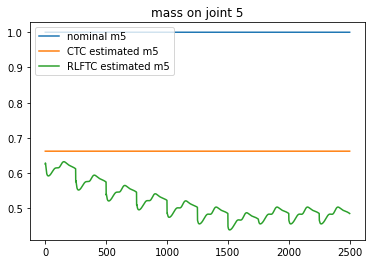

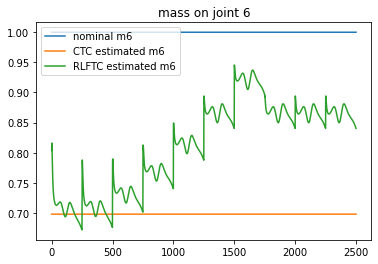

In [87]:
ftc_masses = np.array(ftc_masses)

for i in range(7):
    fig, ax = plt.subplots()
    ax.set_title("mass on joint "+str(i))
    ax.plot(np.ones((2500,1)), label="nominal m"+str(i))
    ax.plot(np.ones((2500,1))*PRODUCTION_env_ftc.noise_on_masses[i], label="CTC estimated m"+str(i))
    ax.plot(PRODUCTION_env_ftc.noise_on_masses[i] * (1 + ftc_masses[:,i]), label="RLFTC estimated m"+str(i))
    
    ax.legend(loc="upper left")

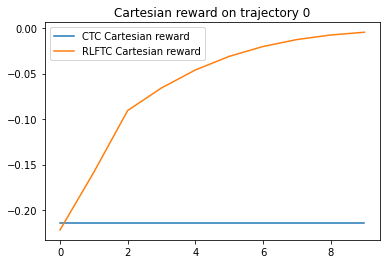

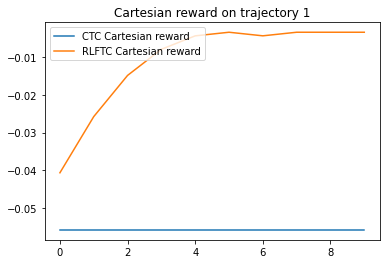

In [90]:
fig, ax = plt.subplots()
ax.set_title("Cartesian reward on trajectory 0")
ax.plot(np.ones((10,1))*-0.21483, label="CTC Cartesian reward")
ax.plot([-0.22194219261389656,-0.1583738977639627,-0.0905774725929945,-0.06575665253710651,-0.046020245990378524,-0.0310679905410432,-0.020179927259963395,-0.012570318338964702,-0.007525727727186664,-0.0044894896501197], label="RLFTC Cartesian reward")

ax.legend(loc="upper left")


fig, ax = plt.subplots()
ax.set_title("Cartesian reward on trajectory 1")
ax.plot(np.ones((10,1))*-0.05579, label="CTC Cartesian reward")
ax.plot([-0.040638830437220844,-0.025747213717205033,-0.014825314285595569,-0.007892023191361109,-0.004332698688163275,-0.003375011276302971,-0.004324622515821613,-0.003375011276302976,-0.0033750112763029755,-0.0033750112763029755], label="RLFTC Cartesian reward")

ax.legend(loc="upper left")

# MEANS AND STDEVS

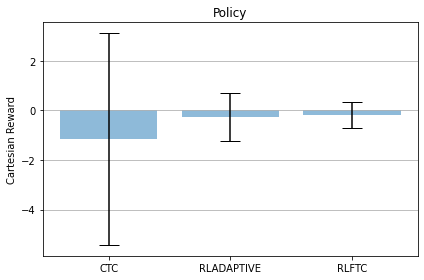

In [437]:
# TRAIN
materials = ["CTC", "RLADAPTIVE", "RLFTC"]
x_pos = np.arange(len(materials))
vals = [total_mean_ctc, total_mean_rla, total_mean_rlftc]
stds = [total_std_ctc, total_std_rla, total_std_rlftc]

fig, ax = plt.subplots()

ax.bar(x_pos, vals, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Cartesian Reward')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Policy')
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

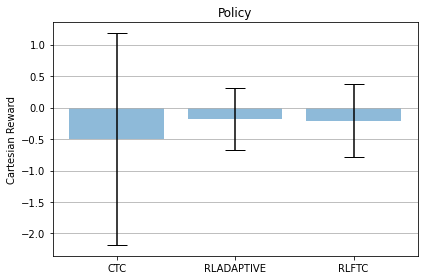

In [438]:
# TEST
materials = ["CTC", "RLADAPTIVE", "RLFTC"]
x_pos = np.arange(len(materials))
vals = [total_mean_ctc_test, total_mean_rla_test, total_mean_rlftc_test]
stds = [total_std_ctc_test, total_std_rla_test, total_std_rlftc_test]

fig, ax = plt.subplots()

ax.bar(x_pos, vals, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Cartesian Reward')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Policy')
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

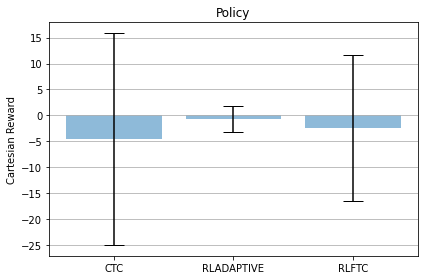

In [439]:
# PROD
materials = ["CTC", "RLADAPTIVE", "RLFTC"]
x_pos = np.arange(len(materials))
vals = [total_mean_ctc_prod, total_mean_rla_prod, total_mean_rlftc_prod]
stds = [total_std_ctc_prod, total_std_rla_prod, total_std_rlftc_prod]

fig, ax = plt.subplots()

ax.bar(x_pos, vals, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Cartesian Reward')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Policy')
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

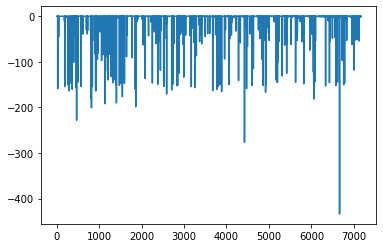

In [465]:
#print train trend
fres = open("tmp/FINAL_exp55/monitor.csv", "r")
fres.readline()
fres.readline()
array_to_print = fres.readlines()
final_print = []
for el in array_to_print:
    if float(el.split(",")[0]) <= 0:
        final_print.append(float(el.split(",")[0]))
plt.plot(final_print)